**Capstone Project: Machine Learning-Driven Long/Short Pair Trading Strategies in Cryptocurrencies**

Members
1. Gabriel Odero
2. Patroba Amara
3. Walter Atati

##**1. Environment Setup**

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime
import yfinance as yf
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy import stats
import time
import platform
import keras_tuner as kt

import warnings
warnings.filterwarnings("ignore")

**2. Data Collection & Preprocessing**

##**2.Cryptocurrency Data (Yahoo Finance)**

In [ ]:

# ==========================
# CONFIGURATION
# ==========================

tickers = [
    "BTC-USD",  # Bitcoin
    "ETH-USD",  # Ethereum
    "XRP-USD",  # Ripple
    "LTC-USD",  # Litecoin
    "ADA-USD",  # Cardano
    "DOT-USD",  # Polkadot
    "SOL-USD",  # Solana
    "AVAX-USD", # Avalanche
    "BNB-USD"   # Binance Coin
]

start_date = "2016-09-30"
end_date = "2025-09-29"

# ==========================
# DOWNLOAD & COMBINE DATA
# ==========================

print("📥 Downloading daily closing prices (including weekends)...")

# Create an empty DataFrame for aligned daily data
all_prices = pd.DataFrame()

# Generate continuous daily date index including weekends
full_dates = pd.date_range(start=start_date, end=end_date, freq='D')

for ticker in tickers:
    print(f"Fetching {ticker}...")
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

    if not df.empty:
        df = df[['Close']].rename(columns={'Close': ticker})
        df = df.reindex(full_dates)  # ensure all dates including weekends
        df[ticker] = df[ticker].ffill()  # forward-fill weekends
        all_prices = pd.concat([all_prices, df[ticker]], axis=1)
    else:
        print(f"⚠️ Warning: No data found for {ticker}")

# Set Date as column
all_prices.index.name = "Date"
all_prices.reset_index(inplace=True)

# ==========================
# SAVE TO EXCEL
# ==========================

output_file = "crypto_prices_9yrs_full.xlsx"
sheet_name = "Closing_Prices"

all_prices.to_excel(output_file, sheet_name=sheet_name, index=False)

print(f"✅ Completed! Saved all daily (incl. weekend) closing prices to '{output_file}' (sheet: {sheet_name})")


📥 Downloading daily closing prices (including weekends)...
Fetching BTC-USD...


[*********************100%***********************]  1 of 1 completed


Fetching ETH-USD...


[*********************100%***********************]  1 of 1 completed


Fetching XRP-USD...


[*********************100%***********************]  1 of 1 completed


Fetching LTC-USD...


[*********************100%***********************]  1 of 1 completed


Fetching ADA-USD...


[*********************100%***********************]  1 of 1 completed


Fetching DOT-USD...


[*********************100%***********************]  1 of 1 completed


Fetching SOL-USD...


[*********************100%***********************]  1 of 1 completed


Fetching AVAX-USD...


[*********************100%***********************]  1 of 1 completed


Fetching BNB-USD...


[*********************100%***********************]  1 of 1 completed


✅ Completed! Saved all daily (incl. weekend) closing prices to 'crypto_prices_9yrs_full.xlsx' (sheet: Closing_Prices)


##**3. Exploratory Data Analysis (EDA)**

✅ Combined price data shape: (1867, 9)


Ticker,BTC-USD,ETH-USD,XRP-USD,LTC-USD,ADA-USD,DOT-USD,SOL-USD,AVAX-USD,BNB-USD
Date,,,,,,,,,
2020-08-20,11878.372070,416.439789,0.292573,62.966755,0.133642,2.900080,3.208267,4.986754,23.092575
2020-08-21,11592.489258,389.126343,0.280682,59.379021,0.123760,2.875028,2.943668,4.986754,22.128994
2020-08-22,11681.825195,395.835144,0.286546,60.311157,0.125276,4.484690,3.020886,4.986754,22.239820
2020-08-23,11664.847656,391.384491,0.285386,60.623260,0.121595,3.967066,3.322431,4.986754,21.870842
2020-08-24,11774.595703,408.144196,0.289215,62.199425,0.124488,4.602614,3.344986,4.986754,22.605852



📊 Price Summary Statistics:


Ticker,BTC-USD,ETH-USD,XRP-USD,LTC-USD,ADA-USD,DOT-USD,SOL-USD,AVAX-USD,BNB-USD
count,1867.00,1867.00,1867.00,1867.00,1867.00,1867.00,1867.00,1867.00,1867.00
mean,49326.75,2339.94,0.91,102.94,0.71,11.29,88.59,29.88,400.01
std,28735.44,1014.16,0.78,50.17,0.53,10.65,72.96,23.52,207.24
min,10131.52,321.12,0.21,43.06,0.08,2.88,1.21,2.91,19.48
25%,26826.09,1640.44,0.46,68.81,0.35,4.67,22.18,14.86,261.76
50%,42270.53,2241.98,0.58,87.83,0.51,6.40,62.43,22.92,344.18
75%,64078.28,3117.95,0.99,119.65,0.92,13.79,150.86,35.97,580.78
max,123344.06,4831.35,3.56,386.45,2.97,53.88,261.87,134.53,1048.67


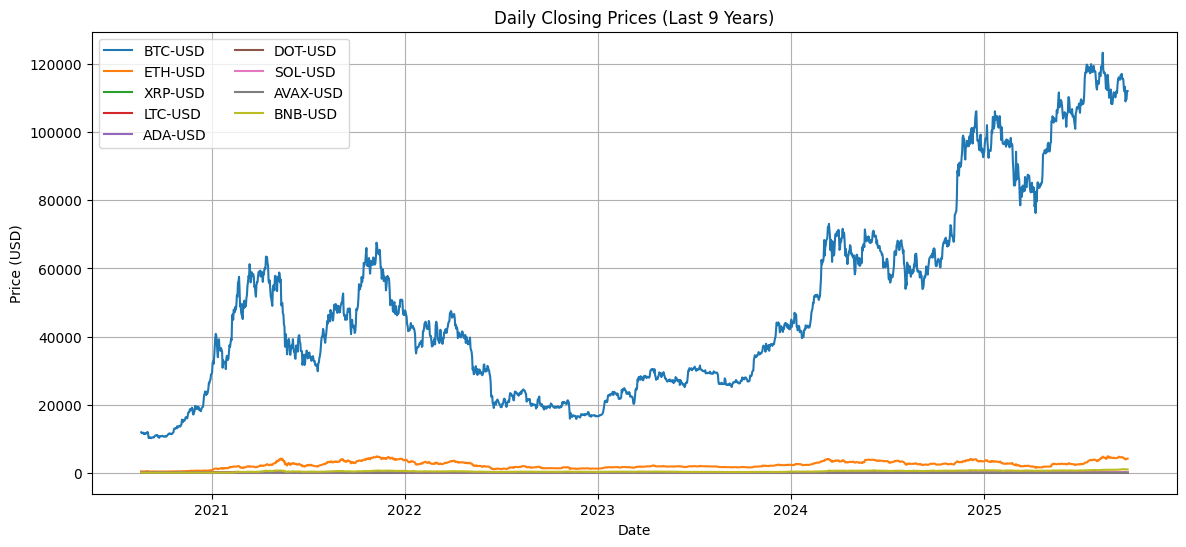


📈 Daily Returns Sample:


Ticker,BTC-USD,ETH-USD,XRP-USD,LTC-USD,ADA-USD,DOT-USD,SOL-USD,AVAX-USD,BNB-USD
Date,,,,,,,,,
2020-08-21,-2.406751,-6.558798,-4.064287,-5.697823,-7.394384,-0.863841,-8.247415,0.0,-4.172688
2020-08-22,0.770636,1.724068,2.089195,1.569808,1.224951,55.987710,2.623192,0.0,0.500820
2020-08-23,-0.145333,-1.124370,-0.404820,0.517488,-2.938310,-11.542027,9.982010,0.0,-1.659089
2020-08-24,0.940844,4.282159,1.341692,2.599933,2.379210,16.020602,0.678867,0.0,3.360685
2020-08-25,-3.469002,-5.915350,-3.902974,-5.817995,-8.993640,20.005572,-2.395707,0.0,-5.000853



📊 Returns Summary Statistics:


Ticker,BTC-USD,ETH-USD,XRP-USD,LTC-USD,ADA-USD,DOT-USD,SOL-USD,AVAX-USD,BNB-USD
count,1866.00,1866.00,1866.00,1866.00,1866.00,1866.00,1866.00,1866.00,1866.00
mean,0.17,0.21,0.28,0.13,0.23,0.16,0.42,0.28,0.30
std,3.09,4.16,5.73,4.57,5.27,5.45,6.33,6.25,4.45
min,-15.97,-27.20,-42.33,-35.67,-26.01,-37.93,-42.28,-36.50,-33.27
25%,-1.27,-1.78,-1.98,-2.09,-2.41,-2.70,-3.01,-2.96,-1.45
50%,0.04,0.10,0.05,0.14,0.02,-0.05,-0.02,0.00,0.14
75%,1.52,2.14,2.03,2.23,2.32,2.53,3.32,3.04,1.85
max,18.75,25.95,73.08,28.20,71.33,55.99,47.28,75.00,69.76


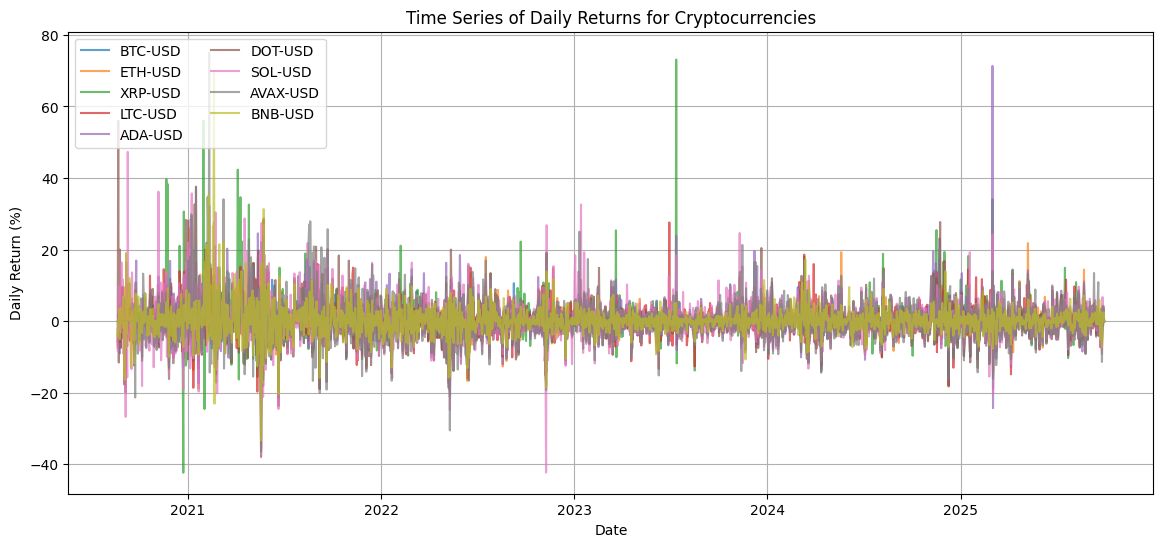

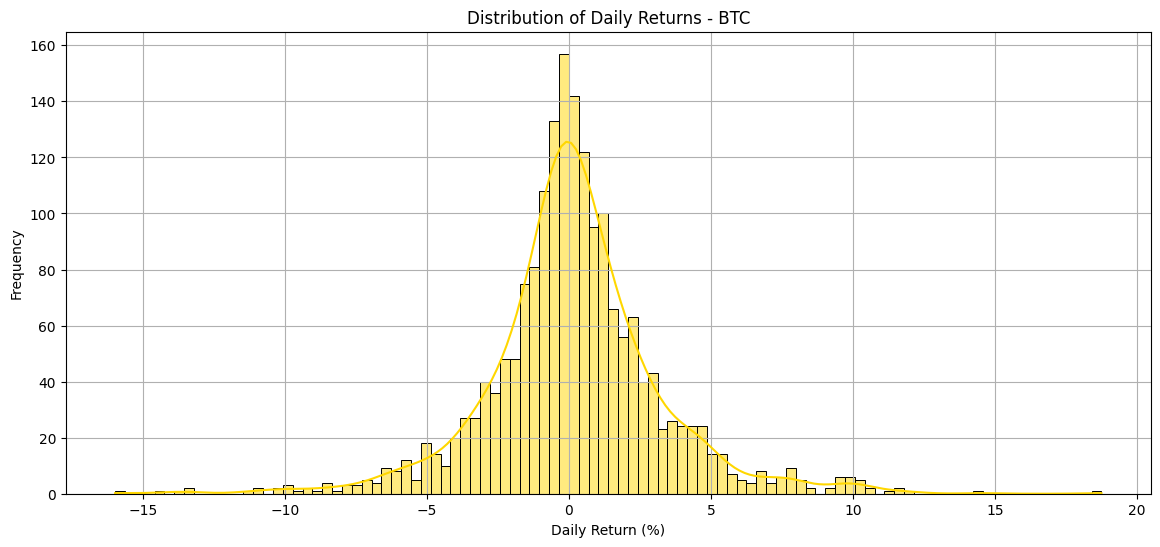

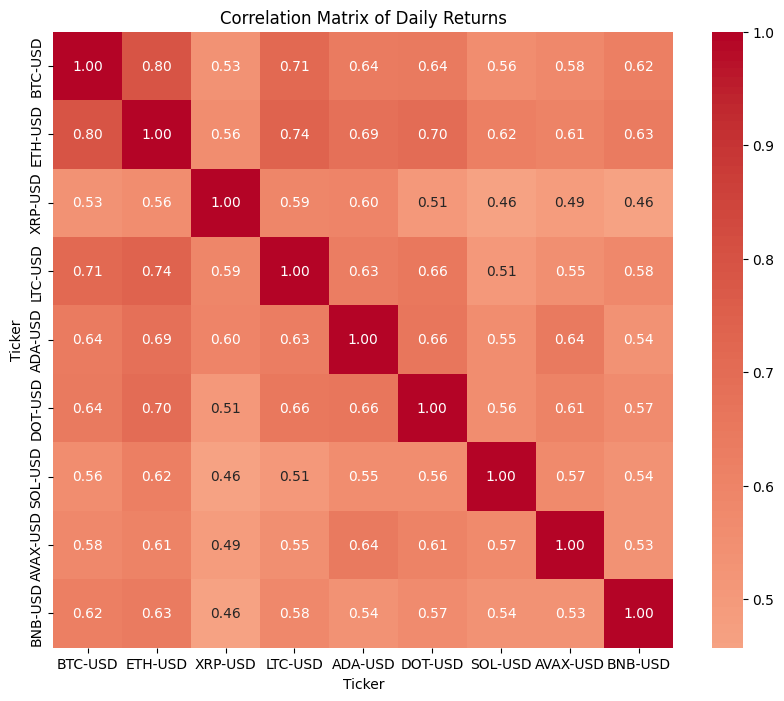

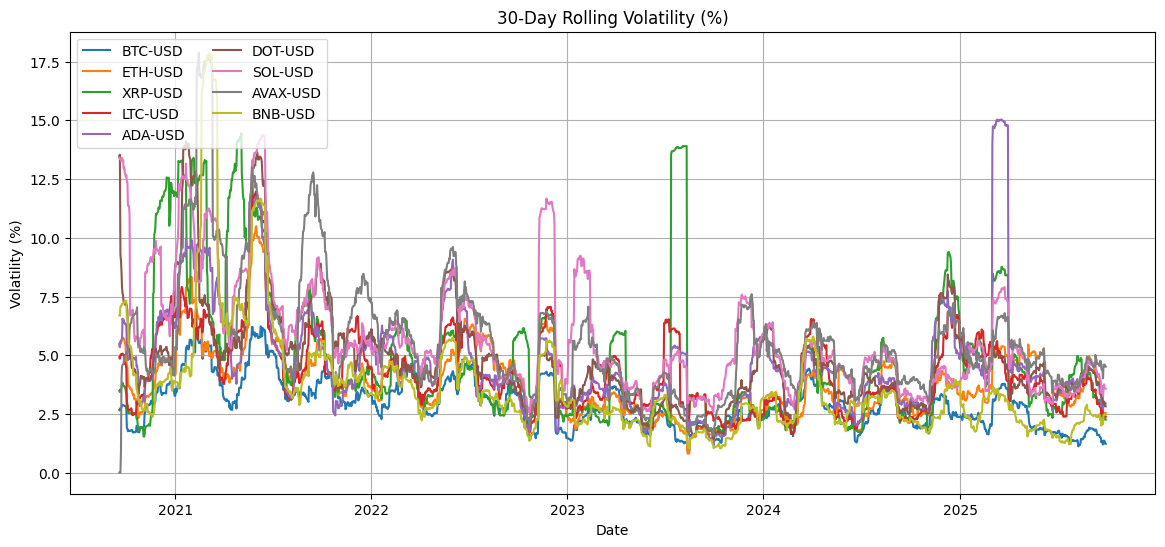


📊 Regime Periods:
During COVID: 2020-01-01 → 2021-12-31 (498 days)
Post-COVID:  2022-01-01 → 2025-09-29 (1368 days)

📈 Mean Returns by Regime (%):


,During COVID,Post-COVID
Ticker,,
BTC-USD,0.350,0.102
ETH-USD,0.578,0.076
XRP-USD,0.522,0.188
LTC-USD,0.348,0.056
ADA-USD,0.668,0.069
DOT-USD,0.745,-0.051
SOL-USD,1.171,0.150
AVAX-USD,0.980,0.031
BNB-USD,0.854,0.093



📉 Volatility (Std Dev) by Regime (%):


,During COVID,Post-COVID
Ticker,,
BTC-USD,3.918,2.728
ETH-USD,5.279,3.666
XRP-USD,8.072,4.592
LTC-USD,5.896,3.977
ADA-USD,6.560,4.707
DOT-USD,7.895,4.198
SOL-USD,8.734,5.162
AVAX-USD,8.777,5.004
BNB-USD,7.033,2.987


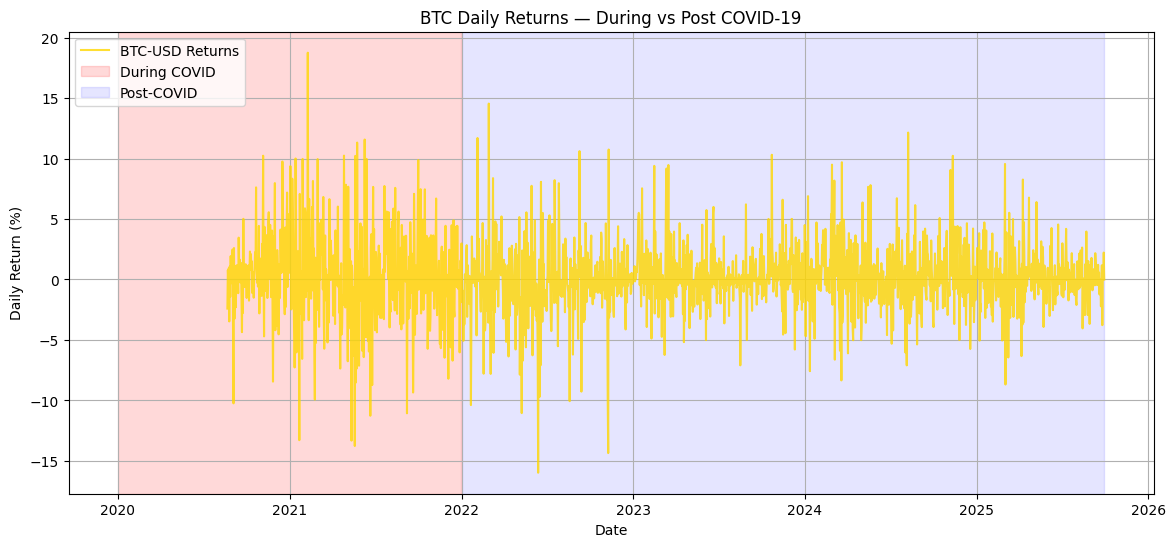

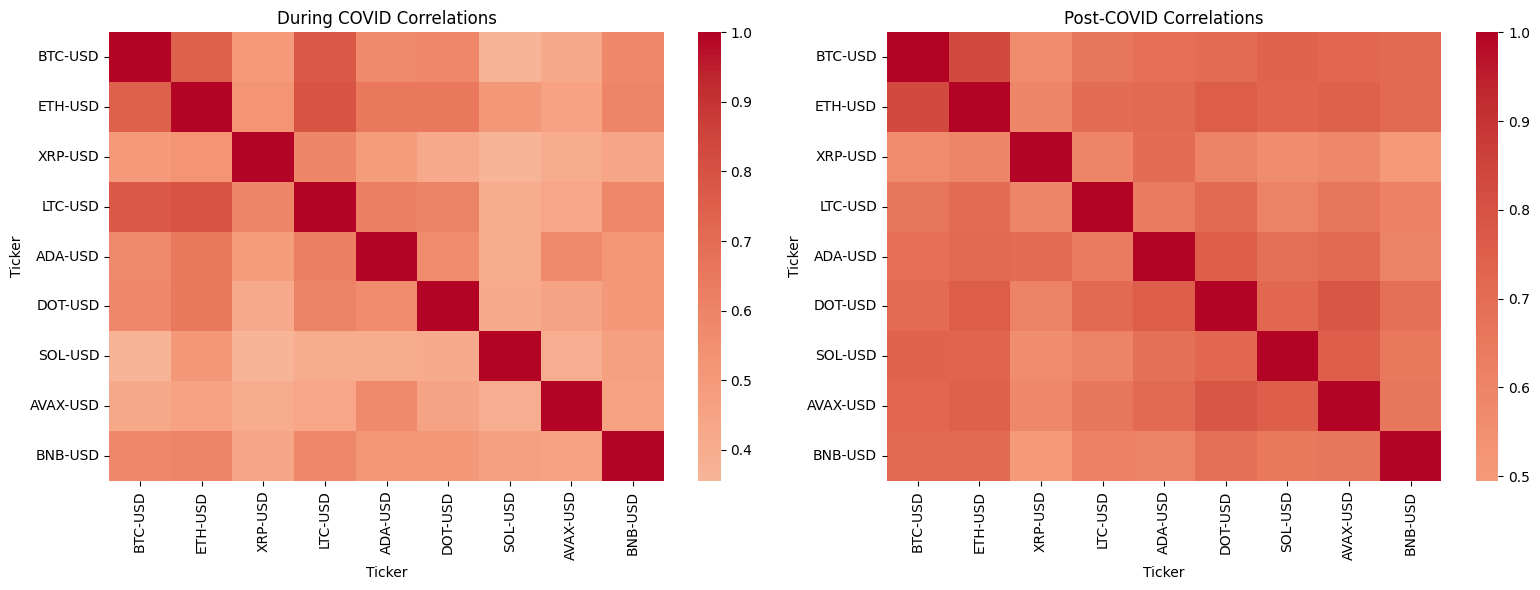

In [ ]:
# ==========================
# STEP 3: EDA on Prices, Returns, and COVID-19 Regime Analysis
# ==========================

# Use the DataFrame created earlier
price_df = all_prices.copy()

# Set Date as index
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.set_index('Date', inplace=True)

# Drop rows with any missing values (optional)
price_df.dropna(inplace=True)

print("✅ Combined price data shape:", price_df.shape)
display(price_df.head())

# ==========================
# Summary Statistics
# ==========================
print("\n📊 Price Summary Statistics:")
display(price_df.describe().round(2))

# ==========================
# Price Trend Visualization
# ==========================
plt.figure(figsize=(14, 6))
for col in price_df.columns:
    plt.plot(price_df.index, price_df[col], label=col)
plt.title("Daily Closing Prices (Last 9 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()

# ==========================
# Daily Returns
# ==========================
returns_df = price_df.pct_change().dropna() * 100  # percentage returns

print("\n📈 Daily Returns Sample:")
display(returns_df.head())

print("\n📊 Returns Summary Statistics:")
display(returns_df.describe().round(2))

# ==========================
# Time Series of Daily Returns
# ==========================
plt.figure(figsize=(14, 6))
for col in returns_df.columns:
    plt.plot(returns_df.index, returns_df[col], label=col, alpha=0.7)
plt.title("Time Series of Daily Returns for Cryptocurrencies")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()

# ==========================
# Plot Returns Distribution (for BTC if present)
# ==========================
if 'BTC-USD' in returns_df.columns:
    plt.figure(figsize=(14, 6))
    sns.histplot(returns_df['BTC-USD'], bins=100, kde=True, color='gold')
    plt.title("Distribution of Daily Returns - BTC")
    plt.xlabel("Daily Return (%)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# ==========================
# Correlation Matrix (Returns)
# ==========================
corr = returns_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Daily Returns")
plt.show()

# ==========================
# Rolling Volatility (30-day)
# ==========================
rolling_vol = returns_df.rolling(window=30).std()

plt.figure(figsize=(14, 6))
for col in rolling_vol.columns:
    plt.plot(rolling_vol.index, rolling_vol[col], label=col)
plt.title("30-Day Rolling Volatility (%)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()

# ==========================
# REGIME ANALYSIS: During COVID vs Post-COVID
# ==========================

# Define COVID-19 and post-COVID periods
during_covid = ('2020-01-01', '2021-12-31')
post_covid = ('2022-01-01', price_df.index.max().strftime('%Y-%m-%d'))

# Segment returns by regime
returns_covid = returns_df.loc[during_covid[0]:during_covid[1]]
returns_post = returns_df.loc[post_covid[0]:post_covid[1]]

print("\n📊 Regime Periods:")
print(f"During COVID: {during_covid[0]} → {during_covid[1]} ({len(returns_covid)} days)")
print(f"Post-COVID:  {post_covid[0]} → {post_covid[1]} ({len(returns_post)} days)")

# Summary stats per regime
print("\n📈 Mean Returns by Regime (%):")
mean_returns = pd.DataFrame({
    "During COVID": returns_covid.mean(),
    "Post-COVID": returns_post.mean()
}).round(3)
display(mean_returns)

print("\n📉 Volatility (Std Dev) by Regime (%):")
volatility = pd.DataFrame({
    "During COVID": returns_covid.std(),
    "Post-COVID": returns_post.std()
}).round(3)
display(volatility)

# ==========================
# Plot BTC Returns with Regime Shading
# ==========================
if 'BTC-USD' in returns_df.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(returns_df.index, returns_df['BTC-USD'], label='BTC-USD Returns', color='gold', alpha=0.8)
    plt.axvspan(during_covid[0], during_covid[1], color='red', alpha=0.15, label='During COVID')
    plt.axvspan(post_covid[0], post_covid[1], color='blue', alpha=0.1, label='Post-COVID')
    plt.title("BTC Daily Returns — During vs Post COVID-19")
    plt.xlabel("Date")
    plt.ylabel("Daily Return (%)")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

# ==========================
# Correlation Comparison: During vs Post COVID
# ==========================
corr_covid = returns_covid.corr()
corr_post = returns_post.corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(corr_covid, annot=False, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("During COVID Correlations")

sns.heatmap(corr_post, annot=False, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Post-COVID Correlations")

plt.tight_layout()
plt.show()


##**4. Co-integration Test (Pairs Selection)**

Running Engle-Granger Cointegration Tests...

Found 1 co-integrated pairs (p < 0.05):
  • LTC-USD & DOT-USD → p = 0.0441


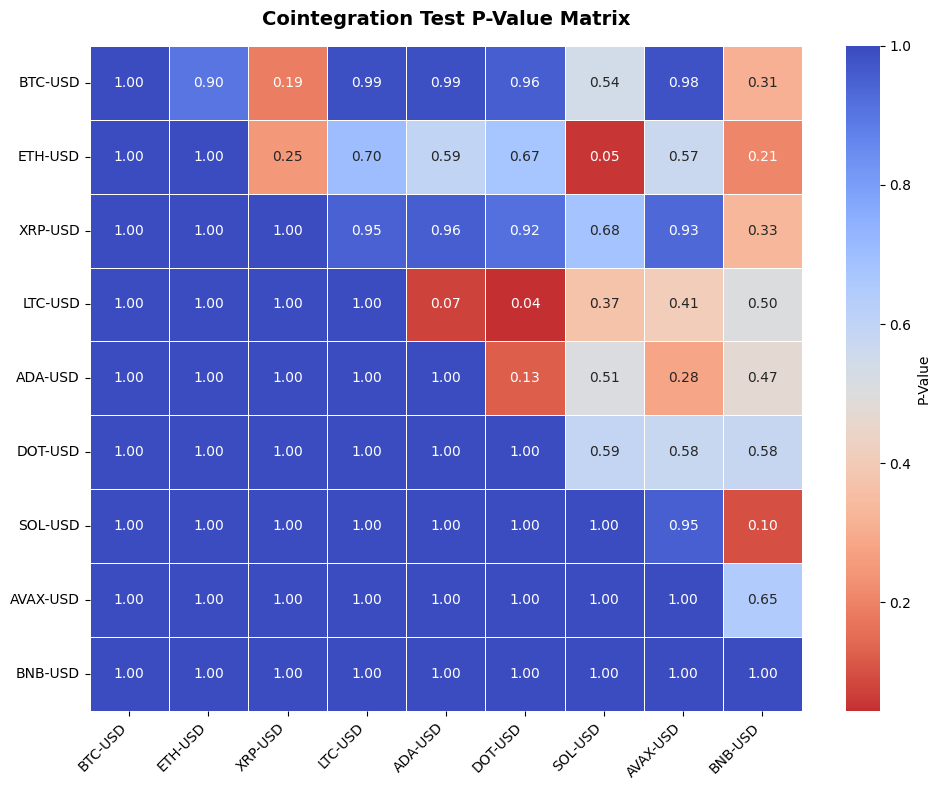

In [ ]:
# ======================================
# 4. COINTEGRATION TEST (PAIRS SELECTION)
# ======================================

# ==========================
# FUNCTION: Find Co-integrated Pairs
# ==========================

def find_cointegrated_pairs(data: pd.DataFrame, pvalue_threshold: float = 0.05):
    """
    Runs Engle-Granger cointegration tests on all column pairs in `data`.

    Parameters:
        data (pd.DataFrame): Price data (columns = asset symbols, rows = time)
        pvalue_threshold (float): Significance threshold for cointegration

    Returns:
        pvalue_matrix (ndarray): matrix of p-values
        pairs (list): list of tuples (asset1, asset2, p-value)
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = np.ones((n, n))
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series_i = data[keys[i]].dropna()
            series_j = data[keys[j]].dropna()

            # Align both series by date
            combined = pd.concat([series_i, series_j], axis=1).dropna()
            if combined.shape[0] < 100:  # Skip if overlap is too short
                continue

            try:
                score, pvalue, _ = coint(combined.iloc[:, 0], combined.iloc[:, 1])
                pvalue_matrix[i, j] = pvalue
                if pvalue < pvalue_threshold:
                    pairs.append((keys[i], keys[j], round(pvalue, 4)))
            except Exception as e:
                print(f"⚠️ Error testing {keys[i]} and {keys[j]}: {e}")
                continue

    return pvalue_matrix, pairs

# ==========================
# RUN CO-INTEGRATION TEST
# ==========================

#Replace with your DataFrame (from crypto_prices_9yrs_full.xlsx)
# Example:
# price_df = pd.read_excel("crypto_prices_9yrs_full.xlsx", sheet_name="Closing_Prices", index_col="Date", parse_dates=True)

print("Running Engle-Granger Cointegration Tests...")
p_matrix, coint_pairs = find_cointegrated_pairs(price_df, pvalue_threshold=0.05)

# Display Results
print(f"\nFound {len(coint_pairs)} co-integrated pairs (p < 0.05):")
for a, b, p in coint_pairs:
    print(f"  • {a} & {b} → p = {p}")

# ==========================
# VISUALIZE P-VALUE HEATMAP
# ==========================

plt.figure(figsize=(10, 8))

sns.heatmap(
    p_matrix,
    xticklabels=price_df.columns,
    yticklabels=price_df.columns,
    cmap="coolwarm_r",
    center=0.5,
    annot=True,        # show p-values
    fmt=".2f",         # 2 decimal places
    linewidths=0.5,
    cbar_kws={"label": "P-Value"}
)

plt.title("Cointegration Test P-Value Matrix", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##**5. Feature Engineering**

In [ ]:
# ==========================
# STEP 5: FEATURE ENGINEERING
# ==========================

# ✅ 1. Calculate log returns
log_returns = np.log(price_df / price_df.shift(1)).dropna()

print("✅ Log returns calculated:")
display(log_returns.head())

# ✅ 2. Select first cointegrated pair
if len(coint_pairs) == 0:
    raise ValueError("No cointegrated pairs found. Please run Step 4 first.")

pair = coint_pairs[0]  # (asset1, asset2, p-value)
asset1, asset2 = pair[0], pair[1]
print(f"\n📈 Selected Co-integrated Pair: {asset1} / {asset2} (p={pair[2]})")

# ✅ 3. Create spread
spread = price_df[asset1] - price_df[asset2]
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean) / spread_std

# ✅ 4. Combine into feature dataframe
features_df = pd.DataFrame({
    "Spread": spread,
    "Z_Score": z_score,
    f"{asset1}_Return": log_returns[asset1],
    f"{asset2}_Return": log_returns[asset2]
})

# ✅ 5. Add optional technical indicators
features_df["Spread_MA_5"] = features_df["Spread"].rolling(5).mean()
features_df["Spread_MA_20"] = features_df["Spread"].rolling(20).mean()
features_df["Spread_Volatility_20"] = features_df["Spread"].rolling(20).std()
features_df["Z_Score_Lag1"] = features_df["Z_Score"].shift(1)

features_df.dropna(inplace=True)

print("\n✅ Engineered Features:")
display(features_df.head())

# ==========================
# OPTIONAL: SAVE TO FILE
# ==========================
output_file = f"features_{asset1}_{asset2}.xlsx"
features_df.to_excel(output_file, index=True)
print(f"\n✅ Feature dataset saved to '{output_file}'")


✅ Log returns calculated:


Ticker,BTC-USD,ETH-USD,XRP-USD,LTC-USD,ADA-USD,DOT-USD,SOL-USD,AVAX-USD,BNB-USD
Date,,,,,,,,,
2020-08-21,-0.024362,-0.067838,-0.041492,-0.058666,-0.076820,-0.008676,-0.086075,0.0,-0.042622
2020-08-22,0.007677,0.017094,0.020677,0.015576,0.012175,0.444607,0.025894,0.0,0.004996
2020-08-23,-0.001454,-0.011307,-0.004056,0.005162,-0.029823,-0.122643,0.095147,0.0,-0.016730
2020-08-24,0.009364,0.041930,0.013328,0.025667,0.023513,0.148598,0.006766,0.0,0.033054
2020-08-25,-0.035306,-0.060975,-0.039812,-0.059941,-0.094241,0.182368,-0.024249,0.0,-0.051302



📈 Selected Co-integrated Pair: LTC-USD / DOT-USD (p=0.0441)

✅ Engineered Features:


,Spread,Z_Score,LTC-USD_Return,DOT-USD_Return,Spread_MA_5,Spread_MA_20,Spread_Volatility_20,Z_Score_Lag1
Date,,,,,,,,
2020-09-08,43.109477,-1.176044,-0.028837,-0.072271,43.894396,51.322263,5.773209,-1.150218
2020-09-09,43.188758,-1.174123,0.010787,0.096837,43.438960,50.478367,5.660178,-1.176044
2020-09-10,44.135270,-1.151191,0.016958,-0.027418,43.572610,49.859931,5.642845,-1.174123
2020-09-11,44.444185,-1.143707,0.007625,0.013869,43.810626,49.290817,5.583081,-1.151191
2020-09-12,45.680117,-1.113764,0.034584,0.100563,44.111561,48.742013,5.355812,-1.143707



✅ Feature dataset saved to 'features_LTC-USD_DOT-USD.xlsx'


**6. ML/DL Modeling**

##**6.Random Forest Regressor (ML baseline)**

✅ Data Loaded: (3287, 9)
Columns: ['BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'ADA-USD', 'DOT-USD', 'SOL-USD', 'AVAX-USD', 'BNB-USD']
✅ Log Returns Calculated: (1866, 9)
✅ Features Ready: (1863, 12)
             BTC_ret  BTC_ret_lag1  BTC_ret_lag2  ETH-USD_ret  XRP-USD_ret  \
Date                                                                         
2020-08-23 -0.001454      0.007677     -0.024362    -0.011307    -0.004056   
2020-08-24  0.009364     -0.001454      0.007677     0.041930     0.013328   
2020-08-25 -0.035306      0.009364     -0.001454    -0.060975    -0.039812   
2020-08-26  0.010696     -0.035306      0.009364     0.006399    -0.001570   
2020-08-27 -0.014463      0.010696     -0.035306    -0.009969    -0.047906   

            LTC-USD_ret  ADA-USD_ret  DOT-USD_ret  SOL-USD_ret  AVAX-USD_ret  \
Date                                                                           
2020-08-23     0.005162    -0.029823    -0.122643     0.095147           0.0   
2020-08-24   

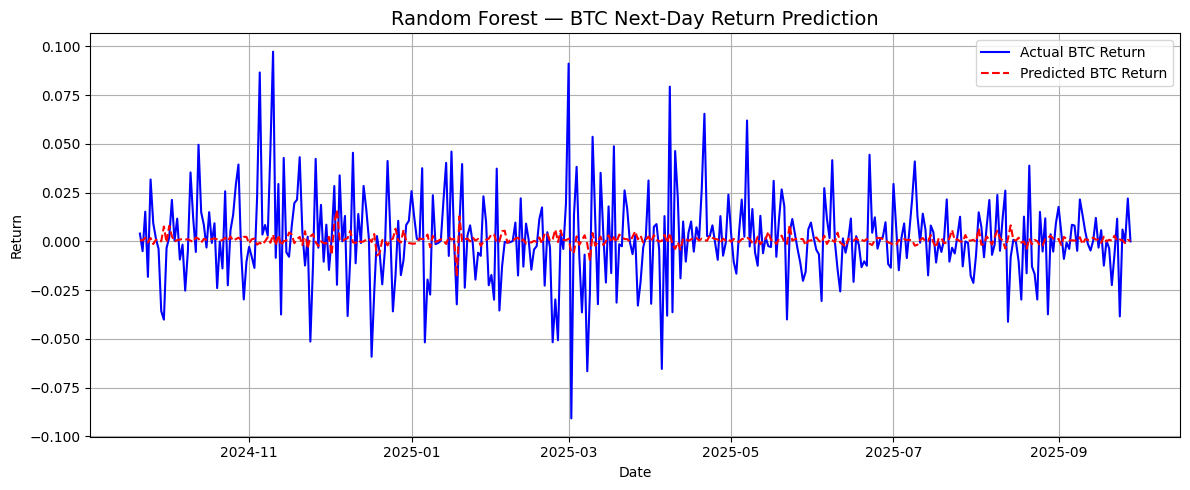

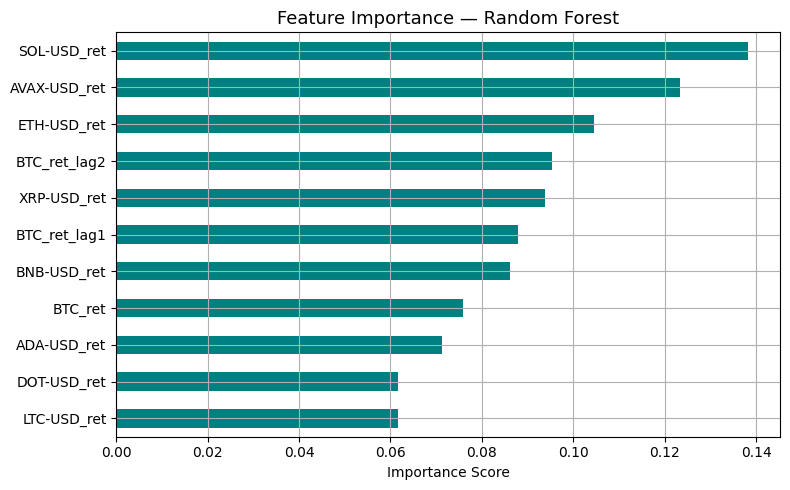


📊 Top 10 Features by Importance:
SOL-USD_ret     0.138333
AVAX-USD_ret    0.123460
ETH-USD_ret     0.104643
BTC_ret_lag2    0.095290
XRP-USD_ret     0.093787
BTC_ret_lag1    0.087877
BNB-USD_ret     0.086120
BTC_ret         0.075944
ADA-USD_ret     0.071199
DOT-USD_ret     0.061726
dtype: float64


In [ ]:
# ============================================================
# Random Forest Regressor — Based on Log Returns (9 Years)
# ============================================================

# ============================================================
# 1. Load Data
# ============================================================
file_path = "crypto_prices_9yrs_full.xlsx"
sheet_name = "Closing_Prices"

# Read prices
prices_df = pd.read_excel(file_path, sheet_name=sheet_name, parse_dates=["Date"])
prices_df.set_index("Date", inplace=True)

print("✅ Data Loaded:", prices_df.shape)
print("Columns:", list(prices_df.columns))

# ============================================================
# 2. Convert Prices → Log Returns
# ============================================================
returns_df = np.log(prices_df / prices_df.shift(1)).dropna()
returns_df = returns_df.replace([np.inf, -np.inf], np.nan).dropna()

print("✅ Log Returns Calculated:", returns_df.shape)

# ============================================================
# 3. Choose Reference Crypto (BTC)
# ============================================================
target_crypto = "BTC-USD"
assert target_crypto in returns_df.columns, f"{target_crypto} not found in data!"

# ============================================================
# 4. Feature Engineering
# ============================================================
features = pd.DataFrame(index=returns_df.index)

# Include BTC's lagged returns as autoregressive features
features["BTC_ret"] = returns_df[target_crypto]
features["BTC_ret_lag1"] = returns_df[target_crypto].shift(1)
features["BTC_ret_lag2"] = returns_df[target_crypto].shift(2)

# Include other cryptos' returns as explanatory features
for col in returns_df.columns:
    if col != target_crypto:
        features[f"{col}_ret"] = returns_df[col]

# Target: next-day BTC return
features["target"] = returns_df[target_crypto].shift(-1)

# Drop NaN caused by shifting
features = features.dropna()

print("✅ Features Ready:", features.shape)
print(features.head())

# ============================================================
# 5. Train/Test Split (80/20, no shuffle — time-series order)
# ============================================================
X = features.drop(columns="target")
y = features["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"🧠 Training Samples: {len(X_train)} | 🧪 Testing Samples: {len(X_test)}")

# ============================================================
# 6. Train Random Forest Regressor
# ============================================================
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42
)

rf.fit(X_train, y_train)
print("✅ Random Forest Model Trained")

# ============================================================
# 7. Evaluate Model
# ============================================================
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n🔹 Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.8f}")
print(f"R² Score: {r2:.4f}")

# ============================================================
# 8. Plot Actual vs Predicted BTC Returns
# ============================================================
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual BTC Return", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted BTC Return", color="red", linestyle="--")
plt.title("Random Forest — BTC Next-Day Return Prediction", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 9. Feature Importance
# ============================================================
importances = pd.Series(rf.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 5))
importances.sort_values(ascending=True).plot(kind="barh", color="teal")
plt.title("Feature Importance — Random Forest", fontsize=13)
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features by Importance:")
print(importances.sort_values(ascending=False).head(10))


🔍 Overfitting Inspection:
OOB R² Score (proxy for generalization): -0.0206


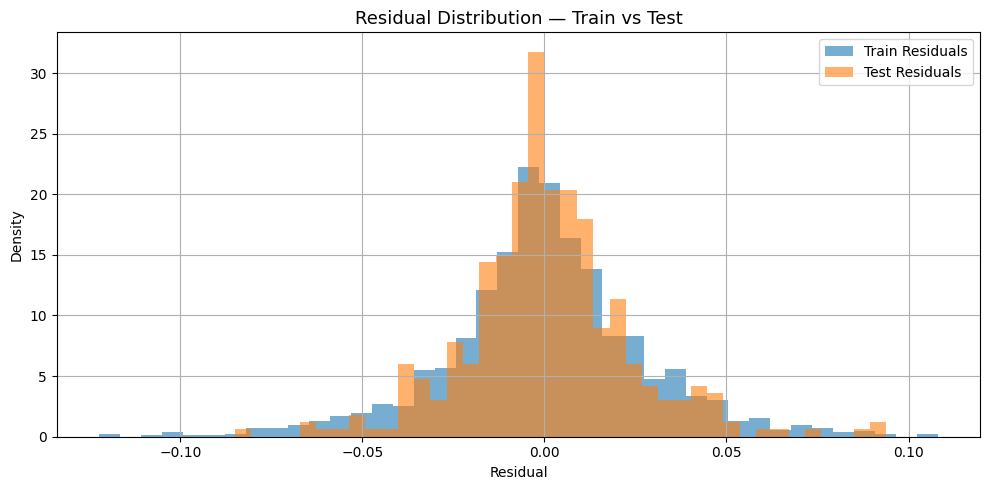

Train Residual Variance: 0.000771
Test Residual Variance: 0.000520
✅ Residuals consistent across train/test — overfitting not severe.


In [ ]:
# ============================================================
# 7.1 Overfitting Inspection (Beyond Train/Test Comparison)
# ============================================================

# Refit model with out-of-bag score enabled
rf_oob = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    oob_score=True
)
rf_oob.fit(X_train, y_train)

print("\n🔍 Overfitting Inspection:")
print(f"OOB R² Score (proxy for generalization): {rf_oob.oob_score_:.4f}")

# Compare in-sample vs. out-of-sample residual distributions
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

train_resid = y_train - train_pred
test_resid = y_test - test_pred

plt.figure(figsize=(10, 5))
plt.hist(train_resid, bins=40, alpha=0.6, label="Train Residuals", density=True)
plt.hist(test_resid, bins=40, alpha=0.6, label="Test Residuals", density=True)
plt.title("Residual Distribution — Train vs Test", fontsize=13)
plt.xlabel("Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual variance comparison
train_var = np.var(train_resid)
test_var = np.var(test_resid)

print(f"Train Residual Variance: {train_var:.6f}")
print(f"Test Residual Variance: {test_var:.6f}")

if test_var > train_var * 1.5:
    print("⚠️ Possible overfitting: test residuals show higher variance than training residuals.")
else:
    print("✅ Residuals consistent across train/test — overfitting not severe.")


##**7.LSTM Deep Learning Model**

Trial 10 Complete [00h 00m 45s]
val_loss: 0.005835408344864845

Best val_loss So Far: 0.00583244115114212
Total elapsed time: 00h 03m 48s

⏱️ Hyperparameter tuning completed in 227.71 seconds (3.80 minutes).

✅ Best Hyperparameters Found:
 - units1: 96
 - dropout1: 0.5
 - units2: 32
 - dropout2: 0.30000000000000004
 - dense_units: 8
 - learning_rate: 0.0001

⏳ Training final LSTM model with optimal parameters...
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1847 - mse: 0.1847 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0059 - val_mse: 0.0059

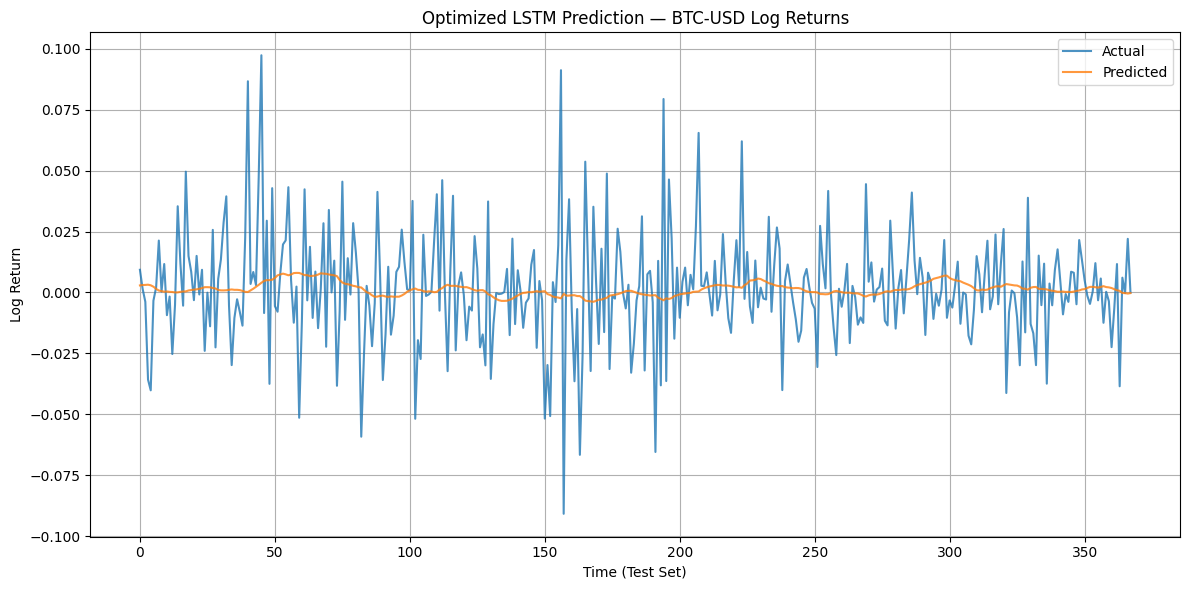


🧮 Computational Summary:
 - Hyperparameter tuning time: 227.71 sec (3.80 min)
 - Final training time: 15.06 sec (0.25 min)
 - Total LSTM runtime: 242.77 sec (4.05 min)
 - Environment: Linux 6.6.105+ | Python 3.12.12
 - GPU not detected; computation done on CPU.


In [ ]:
#============================================================
# LSTM Deep Learning Model with Hyperparameter Tuning & Runtime Reporting
# ============================================================

# ============================================================
# 1. LOAD DATA (Ensure price_df exists)
# ============================================================

# Compute log returns
returns_df = np.log(price_df / price_df.shift(1)).dropna()

# ============================================================
# 2. AUTO TARGET SELECTION
# ============================================================

target = "BTC-USD" if "BTC-USD" in returns_df.columns else returns_df.columns[0]
print(f"✅ Target selected for prediction: {target}")

features = returns_df.columns.tolist()

X = returns_df[features].values
y = returns_df[target].values

# ============================================================
# 3. SCALE DATA
# ============================================================

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# ============================================================
# 4. CREATE SUPERVISED SEQUENCES
# ============================================================

def create_sequences(X, y, lookback=30):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lookback = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback=lookback)

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

# ============================================================
# 5. SYSTEM INFO (Computational Environment)
# ============================================================

print("\n🖥️ System Information:")
print(f"Platform: {platform.system()} {platform.release()}")
print(f"Python version: {platform.python_version()}")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU') != []}")
if tf.config.list_physical_devices('GPU'):
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

# ============================================================
# 6. HYPERPARAMETER TUNING FUNCTION
# ============================================================

def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int('units1', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(Dropout(rate=hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    model.add(
        LSTM(
            units=hp.Int('units2', min_value=16, max_value=64, step=16),
            return_sequences=False
        )
    )
    model.add(Dropout(rate=hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units', 8, 32, step=8), activation='relu'))
    model.add(Dense(1))

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mse'])
    return model

# ============================================================
# 7. RUN HYPERPARAMETER SEARCH (with timing)
# ============================================================

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_returns'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n⏳ Starting hyperparameter search...")
start_tuning = time.time()

tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

end_tuning = time.time()
tuning_time = end_tuning - start_tuning
print(f"\n⏱️ Hyperparameter tuning completed in {tuning_time:.2f} seconds ({tuning_time/60:.2f} minutes).")

# ============================================================
# 8. TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS (timed)
# ============================================================

best_hp = tuner.get_best_hyperparameters(1)[0]
print("\n✅ Best Hyperparameters Found:")
for key, value in best_hp.values.items():
    print(f" - {key}: {value}")

print("\n⏳ Training final LSTM model with optimal parameters...")
start_training = time.time()

best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

end_training = time.time()
training_time = end_training - start_training
print(f"\n⏱️ Final model training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes).")

# ============================================================
# 9. EVALUATE MODEL
# ============================================================

y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n📊 Optimized LSTM Model Performance on Test Set:")
print(f"MSE: {mse:.6f}")
print(f"R²:  {r2:.4f}")

# ============================================================
# 10. VISUALIZE RESULTS
# ============================================================

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title(f"Optimized LSTM Prediction — {target} Log Returns")
plt.xlabel("Time (Test Set)")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 11. REPORT COMPUTATIONAL REQUIREMENTS
# ============================================================

total_time = tuning_time + training_time
print("\n🧮 Computational Summary:")
print(f" - Hyperparameter tuning time: {tuning_time:.2f} sec ({tuning_time/60:.2f} min)")
print(f" - Final training time: {training_time:.2f} sec ({training_time/60:.2f} min)")
print(f" - Total LSTM runtime: {total_time:.2f} sec ({total_time/60:.2f} min)")
print(f" - Environment: {platform.system()} {platform.release()} | Python {platform.python_version()}")
if tf.config.list_physical_devices('GPU'):
    print(f" - GPU used: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print(" - GPU not detected; computation done on CPU.")

In [ ]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 96)         │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,469 (673.71 KB)

 Trainable params: 57,489 (224.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 114,980 (449.14 KB)

##**8.Ensemble for risk-adjusted portfolio allocation**

Price data loaded: (3287, 9)
Columns: ['BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'ADA-USD', 'DOT-USD', 'SOL-USD', 'AVAX-USD', 'BNB-USD']
Returns data created: (1866, 9)

 Training ensemble models for each crypto...

Training on BTC-USD...
BTC-USD: R² = 0.0000
Training on ETH-USD...
ETH-USD: R² = 0.0054
Training on XRP-USD...
XRP-USD: R² = -0.0120
Training on LTC-USD...
LTC-USD: R² = -0.0369
Training on ADA-USD...
ADA-USD: R² = -0.0101
Training on DOT-USD...
DOT-USD: R² = -0.0487
Training on SOL-USD...
SOL-USD: R² = 0.0089
Training on AVAX-USD...
AVAX-USD: R² = -0.0230
Training on BNB-USD...
BNB-USD: R² = -0.0200

Ensemble predictions shape: (373, 9)

Mean predicted returns (mu):
BTC-USD     0.001039
ETH-USD     0.001174
XRP-USD     0.000678
LTC-USD    -0.000445
ADA-USD     0.000462
DOT-USD    -0.000971
SOL-USD     0.002232
AVAX-USD    0.000600
BNB-USD     0.001430
dtype: float64

Covariance matrix (shape): (9, 9)

Optimal Risk-Adjusted Weights:
          Weight
BNB-USD   0.3158
BTC-U

<Figure size 1000x600 with 0 Axes>

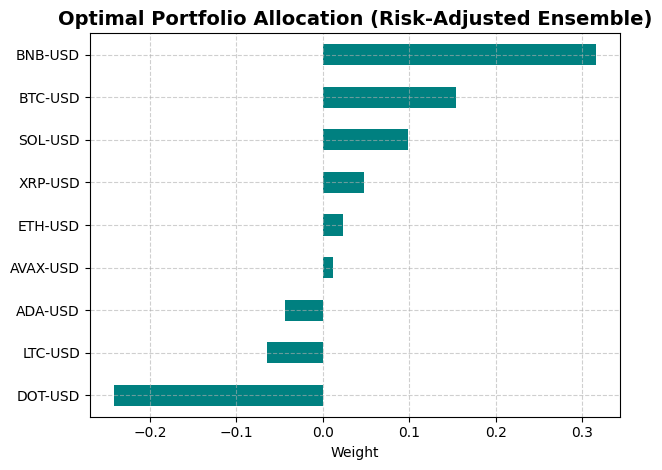

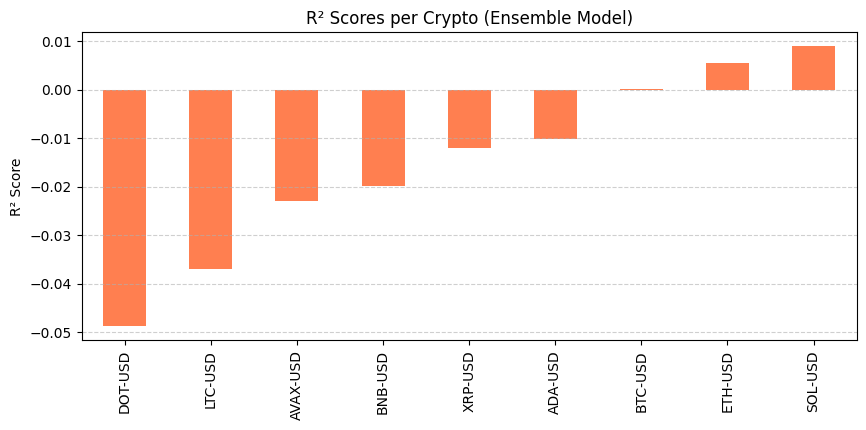

In [ ]:
# ============================================================
# ENSEMBLE MODEL + RISK-ADJUSTED PORTFOLIO ALLOCATION
# ============================================================


# ============================================================
# 1. LOAD DATA (Closing Prices)
# ============================================================

# Replace with your saved Excel file
file_path = "crypto_prices_9yrs_full.xlsx"

price_df = pd.read_excel(
    file_path,
    sheet_name="Closing_Prices",
    index_col="Date",
    parse_dates=True
)

print("Price data loaded:", price_df.shape)
print("Columns:", list(price_df.columns))

# ============================================================
# 2. COMPUTE LOG RETURNS
# ============================================================

returns_df = np.log(price_df / price_df.shift(1)).dropna()
print("Returns data created:", returns_df.shape)

# ============================================================
# 3. DEFINE ENSEMBLE MODELS
# ============================================================

models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42),
    "GradientBoost": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "Linear": LinearRegression()
}

N_LAGS = 3  # use 3-day lags for prediction
ensemble_preds = pd.DataFrame(index=returns_df.index)

# ============================================================
# 4. TRAIN ENSEMBLE MODEL FOR EACH CRYPTO
# ============================================================

print("\n Training ensemble models for each crypto...\n")
metrics = {}

for crypto in returns_df.columns:
    print(f"Training on {crypto}...")
    data = returns_df.copy()

    # Create lag features
    for lag in range(1, N_LAGS + 1):
        data[f"{crypto}_lag{lag}"] = data[crypto].shift(lag)

    # Drop NaN
    data = data.dropna()

    # Features = lagged returns
    X = data[[f"{crypto}_lag{i}" for i in range(1, N_LAGS + 1)]]
    y = data[crypto]

    # Split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ensemble predictions
    preds = []
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        preds.append(pred)

    # Average predictions (ensemble)
    ensemble_pred = np.mean(np.column_stack(preds), axis=1)

    # Store predictions
    ensemble_preds[crypto] = np.nan
    ensemble_preds.loc[y_test.index, crypto] = ensemble_pred

    # Evaluate R²
    r2 = r2_score(y_test, ensemble_pred)
    metrics[crypto] = r2
    print(f"{crypto}: R² = {r2:.4f}")

ensemble_preds = ensemble_preds.dropna()
print("\nEnsemble predictions shape:", ensemble_preds.shape)

# ============================================================
# 5. ESTIMATE MEAN & COVARIANCE
# ============================================================

mu = ensemble_preds.mean()                # expected returns
historical_cov = returns_df.loc[ensemble_preds.index].cov()  # covariance matrix

print("\nMean predicted returns (mu):")
print(mu.round(6))
print("\nCovariance matrix (shape):", historical_cov.shape)

# ============================================================
# 6. RISK-ADJUSTED PORTFOLIO OPTIMIZATION
# ============================================================

# Mean-variance optimization (inverse covariance weighting)
inv_cov = np.linalg.inv(historical_cov.values)
raw_weights = inv_cov @ mu.values

# Normalize (sum = 1)
weights = raw_weights / np.sum(np.abs(raw_weights))
weights_df = pd.DataFrame({"Weight": weights}, index=returns_df.columns)

print("\nOptimal Risk-Adjusted Weights:")
print(weights_df.sort_values("Weight", ascending=False).round(4))

# Portfolio statistics
portfolio_return = np.dot(weights, mu.values)
portfolio_vol = np.sqrt(weights.T @ historical_cov.values @ weights)
sharpe_ratio = portfolio_return / portfolio_vol

print(f"\nPortfolio Expected Return: {portfolio_return:.6f}")
print(f"Portfolio Volatility: {portfolio_vol:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# ============================================================
# 7. VISUALIZE PORTFOLIO ALLOCATION
# ============================================================

plt.figure(figsize=(10, 6))
weights_df.sort_values("Weight", ascending=True).plot.barh(legend=False, color='teal')
plt.title("Optimal Portfolio Allocation (Risk-Adjusted Ensemble)", fontsize=14, fontweight="bold")
plt.xlabel("Weight")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ============================================================
# 8. VISUALIZE ENSEMBLE MODEL PERFORMANCE
# ============================================================

plt.figure(figsize=(10, 4))
pd.Series(metrics).sort_values().plot(kind="bar", color="coral")
plt.title("R² Scores per Crypto (Ensemble Model)")
plt.ylabel("R² Score")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


#**9. Backtesting Long/Short Pairs Strategy**

Loaded returns: (1866, 9) tickers: ['BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'ADA-USD', 'DOT-USD', 'SOL-USD', 'AVAX-USD', 'BNB-USD']

Training Random Forests per asset...
RF predictions done. Shape: (374, 9)

Training LSTM per asset (multivariate inputs)...
LSTM predictions done. Shape: (374, 9)

Aligned prediction shapes: (374, 9) (374, 9) (374, 9)


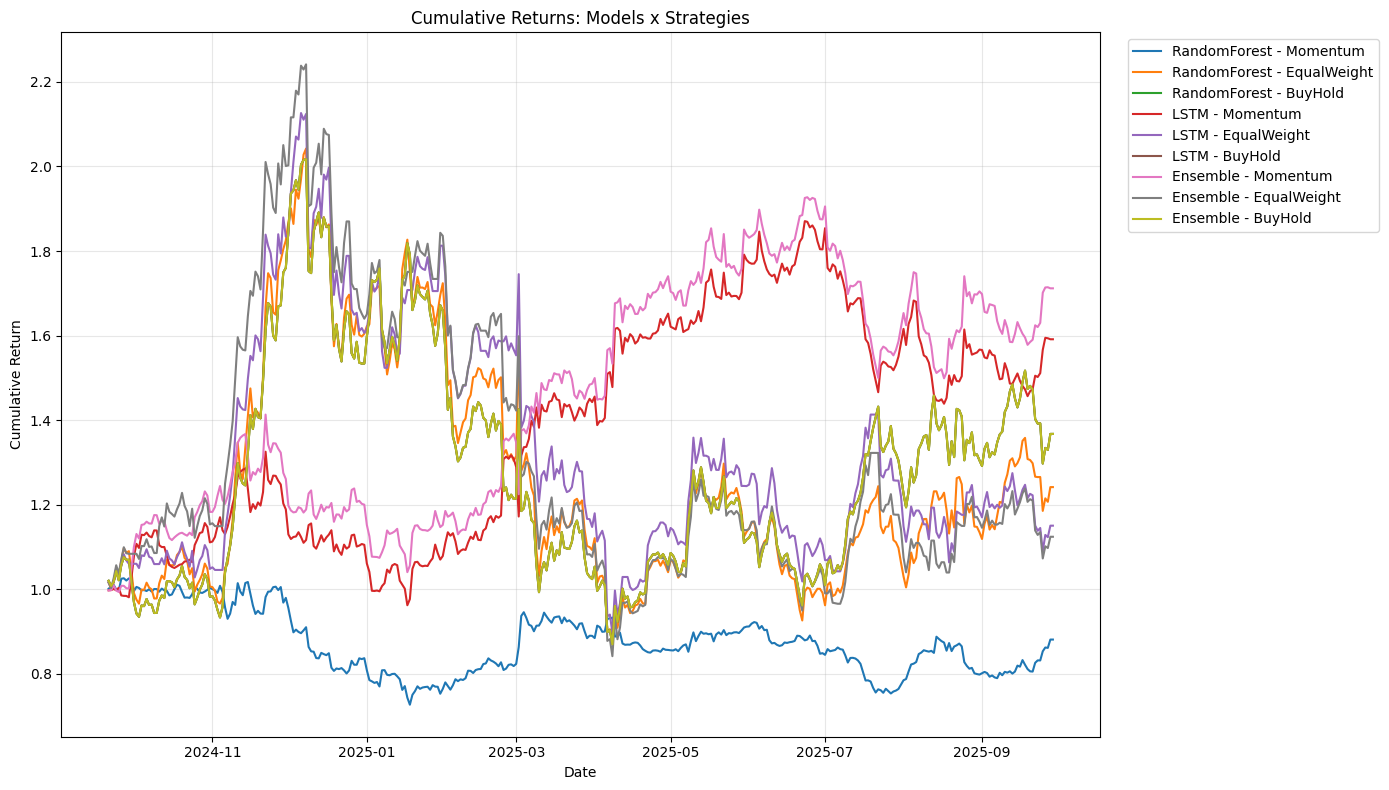


Performance Summary:
          Model     Strategy  TotalReturn  AnnReturn    AnnVol    Sharpe
0      Ensemble     Momentum     0.711868   0.606007  0.405619  1.494032
1          LSTM     Momentum     0.591422   0.536690  0.410905  1.306116
2      Ensemble      BuyHold     0.367580   0.530204  0.668474  0.793157
3          LSTM      BuyHold     0.367580   0.530204  0.668474  0.793157
4  RandomForest      BuyHold     0.367580   0.530204  0.668474  0.793157
5  RandomForest  EqualWeight     0.241849   0.453071  0.693615  0.653201
6          LSTM  EqualWeight     0.150670   0.368621  0.673712  0.547148
7      Ensemble  EqualWeight     0.124438   0.355299  0.686367  0.517652
8  RandomForest     Momentum    -0.118618  -0.083592  0.282445 -0.295958


In [ ]:
# @title
# ============================================================
# FULL BACKTEST: LSTM vs Random Forest vs Ensemble (stacking)
# ============================================================
# ---------------------------
# CONFIG
# ---------------------------
file_path = "crypto_prices_9yrs_full.xlsx"   # <-- set your file
sheet_name = "Closing_Prices"                # <-- set if needed
target_lookback = 5        # lookback days for LSTM sequences
rf_lags = 1                # number of lag days used by RF (using 1 day here)
test_size_ratio = 0.2
rf_trees = 200
lstm_epochs = 20           # reduce for quick testing
random_state = 42

# ---------------------------
# 1) LOAD PRICES -> LOG RETURNS
# ---------------------------
# read Excel (assumes Date column or index)
try:
    prices = pd.read_excel(file_path, sheet_name=sheet_name, index_col="Date", parse_dates=True)
except Exception:
    # fallback: read first sheet and assume index in first col
    prices = pd.read_excel(file_path, index_col=0, parse_dates=True)

prices = prices.sort_index()
returns = np.log(prices / prices.shift(1)).dropna()
tickers = returns.columns.tolist()
print("Loaded returns:", returns.shape, "tickers:", tickers)

# ---------------------------
# 2) TRAIN/TEST SPLIT (time-based)
# ---------------------------
split_idx = int(len(returns) * (1 - test_size_ratio))
train_returns = returns.iloc[:split_idx]
test_returns = returns.iloc[split_idx:]

# We'll create models that predict next-day return:
# For RF: features = lagged returns (1 lag)
# For LSTM: sequences of past `target_lookback` days for all assets (multivariate input)

# ---------------------------
# 3) RANDOM FOREST PREDICTIONS (per asset)
# ---------------------------
rf_preds = pd.DataFrame(index=test_returns.index, columns=tickers)

print("\nTraining Random Forests per asset...")
for asset in tickers:
    # prepare lagged feature DataFrame for whole sample
    df = returns[[asset]].copy()
    for lag in range(1, rf_lags + 1):
        df[f"lag{lag}"] = df[asset].shift(lag)
    df = df.dropna()

    # align train/test split on df
    train_df = df.iloc[:split_idx - (rf_lags)]   # -rf_lags because lagging reduces rows
    test_df = df.iloc[split_idx - (rf_lags):]    # same indexing

    X_train = train_df[[f"lag{l}" for l in range(1, rf_lags + 1)]].values
    y_train = train_df[asset].values
    X_test = test_df[[f"lag{l}" for l in range(1, rf_lags + 1)]].values
    y_test = test_df[asset].values
    idx_test = test_df.index

    # scale features
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    # train RF
    rf = RandomForestRegressor(n_estimators=rf_trees, random_state=random_state)
    rf.fit(X_train_s, y_train)

    # predict
    pred = rf.predict(X_test_s)
    rf_preds.loc[idx_test, asset] = pred

print("RF predictions done. Shape:", rf_preds.shape)

# ---------------------------
# 4) LSTM PREDICTIONS (per asset, multivariate input)
# ---------------------------
# We'll build LSTM using multivariate inputs (all assets' returns) and predict one asset at a time.
def create_sequences_mv(X_array, y_array, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X_array)):
        Xs.append(X_array[i - lookback:i])
        ys.append(y_array[i])
    return np.array(Xs), np.array(ys)

lstm_preds = pd.DataFrame(index=test_returns.index, columns=tickers)
print("\nTraining LSTM per asset (multivariate inputs)...")

# scale full returns using a scaler fitted on train_returns
scaler_all = StandardScaler().fit(train_returns.values)
train_scaled = pd.DataFrame(scaler_all.transform(train_returns.values), index=train_returns.index, columns=tickers)
test_scaled = pd.DataFrame(scaler_all.transform(test_returns.values), index=test_returns.index, columns=tickers)

# build full arrays for sequence creation (concatenate train + test scaled to ensure continuous sequences)
combined_scaled = pd.concat([train_scaled, test_scaled])
combined_index = combined_scaled.index

for asset in tickers:
    # prepare X (multivariate) and y (single asset)
    X_array = combined_scaled.values
    y_array = combined_scaled[asset].values

    # create sequences
    Xs, ys = create_sequences_mv(X_array, y_array, target_lookback)

    # determine train/test split index in sequence space
    # sequences start at combined index position = target_lookback
    seq_start_idx = target_lookback
    seq_train_end = split_idx - seq_start_idx  # number of training sequences
    if seq_train_end <= 0:
        raise RuntimeError("Not enough data for chosen lookback and test_size_ratio")

    Xs_train, Xs_test = Xs[:seq_train_end], Xs[seq_train_end:]
    ys_train, ys_test = ys[:seq_train_end], ys[seq_train_end:]

    # build model (small to speed up)
    model = Sequential([
        Input(shape=(target_lookback, len(tickers))),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    # train
    model.fit(Xs_train, ys_train, epochs=lstm_epochs, batch_size=32, verbose=0)

    # predict on Xs_test
    preds_scaled = model.predict(Xs_test, verbose=0).flatten()

    # map sequence-test indices to actual dates in combined_index
    # Xs_test corresponds to combined_index positions from seq_start_idx + seq_train_end ... end-1
    seq_test_start_pos = seq_start_idx + seq_train_end
    seq_test_positions = np.arange(seq_test_start_pos, seq_test_start_pos + len(Xs_test))
    # the date for a sequence ending at position p corresponds to combined_index[p]
    pred_dates = combined_index[seq_test_positions]
    # but our test_returns index starts at split_idx; ensure alignment:
    # select preds mapped to dates that appear in test_returns.index
    mapped = pd.Series(preds_scaled, index=pred_dates)
    mapped = mapped.reindex(test_returns.index)  # only keep test dates; NaN for early few dates may appear
    lstm_preds[asset] = mapped.values

print("LSTM predictions done. Shape:", lstm_preds.shape)

# ---------------------------
# 5) ENSEMBLE PREDICTIONS (average RF & LSTM where both available)
# ---------------------------
rf_preds = rf_preds.astype(float)
lstm_preds = lstm_preds.astype(float)

# Align indices and drop rows with all-NaN
common_index = rf_preds.index.intersection(lstm_preds.index)
rf_preds = rf_preds.loc[common_index]
lstm_preds = lstm_preds.loc[common_index]
test_returns_aligned = test_returns.loc[common_index]

ensemble_preds = (rf_preds + lstm_preds) / 2.0

# Drop any rows that are fully NaN in ensemble
valid_mask = ~ensemble_preds.isna().all(axis=1)
ensemble_preds = ensemble_preds.loc[valid_mask]
rf_preds = rf_preds.loc[valid_mask]
lstm_preds = lstm_preds.loc[valid_mask]
test_returns_aligned = test_returns_aligned.loc[valid_mask]

print("\nAligned prediction shapes:", rf_preds.shape, lstm_preds.shape, ensemble_preds.shape)

# ---------------------------
# 6) STRATEGIES (Momentum, Equal-weight long-only, Buy & Hold)
# ---------------------------
def compute_portfolio_returns(preds_df, actual_returns_df, mode="momentum"):
    """
    preds_df, actual_returns_df must have same index & columns (tickers).
    mode in {'momentum', 'equal-weight', 'buy-hold'}:
      - momentum: long if pred>0 else short (-1)
      - equal-weight: long-only equal weight across predicted-positive assets
      - buy-hold: equal-weight long-only across all assets (benchmark)
    Returns series of cumulative returns.
    """
    preds = preds_df.copy()
    actual = actual_returns_df.copy()

    if mode == "momentum":
        # signals: 1 for long, -1 for short
        signals = preds.applymap(lambda x: 1 if x > 0 else -1)
        # daily portfolio return = average across assets of (signal * actual return)
        daily = (signals * actual).mean(axis=1)
    elif mode == "equal-weight":
        # long-only: allocate equally among positively predicted assets
        pos = preds > 0
        # compute count of positives each day
        counts = pos.sum(axis=1).replace(0, np.nan)
        weights = pos.div(counts, axis=0).fillna(0)
        daily = (weights * actual).sum(axis=1)
    elif mode == "buy-hold":
        # equal-weight long-only across all assets
        n = actual.shape[1]
        daily = actual.mean(axis=1)
    else:
        raise ValueError("Unknown mode")

    cum = (1 + daily).cumprod().fillna(method="ffill")
    return daily, cum

# compute for models
models_preds = {"RandomForest": rf_preds, "LSTM": lstm_preds, "Ensemble": ensemble_preds}
results = {}
for name, preds in models_preds.items():
    results[(name, "Momentum")] = compute_portfolio_returns(preds, test_returns_aligned, "momentum")
    results[(name, "EqualWeight")] = compute_portfolio_returns(preds, test_returns_aligned, "equal-weight")
    results[(name, "BuyHold")] = compute_portfolio_returns(preds, test_returns_aligned, "buy-hold")

# ---------------------------
# 7) PLOT CUMULATIVE RETURNS
# ---------------------------
plt.figure(figsize=(14, 8))
for (name, strat), (daily, cum) in results.items():
    plt.plot(cum.index, cum.values, label=f"{name} - {strat}")
plt.title("Cumulative Returns: Models x Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------
# 8) SUMMARY METRICS (Total Return, Annualized Vol, Sharpe)
# ---------------------------
summary = []
trading_days_per_year = 365  # using daily including weekends; adjust if using 252

for (name, strat), (daily, cum) in results.items():
    total_return = cum.iloc[-1] - 1
    # compute daily returns series for volatility and Sharpe (use daily, not cumulative)
    daily_ret = daily.dropna()
    ann_vol = daily_ret.std() * np.sqrt(trading_days_per_year)
    ann_ret = daily_ret.mean() * trading_days_per_year
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    summary.append([name, strat, float(total_return), float(ann_ret), float(ann_vol), float(sharpe)])

summary_df = pd.DataFrame(summary, columns=["Model", "Strategy", "TotalReturn", "AnnReturn", "AnnVol", "Sharpe"])
print("\nPerformance Summary:")
print(summary_df.sort_values(["Sharpe"], ascending=False).reset_index(drop=True))


**More Performance summaries**


Performance Summary (with transaction costs & more metrics):
          Model      Strategy  TotalReturn_Gross  TotalReturn_Net  \
0      Ensemble      momentum           0.711868         0.617448   
1          LSTM      momentum           0.591422         0.507344   
2      Ensemble      buy-hold           0.367580         0.367580   
3          LSTM      buy-hold           0.367580         0.367580   
4  RandomForest      buy-hold           0.367580         0.367580   
5  RandomForest  equal-weight           0.241849         0.115437   
6          LSTM  equal-weight           0.150670         0.052735   
7      Ensemble  equal-weight           0.124438         0.027609   
8  RandomForest      momentum          -0.118618        -0.194283   

   AnnReturn_Net  AnnVol_Net  Sharpe_Net  Sortino_Net  HitRatio  AvgTurnover  \
0       0.382640    0.337081    1.135159     1.324360  0.505348     0.303624   
1       0.318496    0.341417    0.932865     1.084823  0.502674     0.290553   
2      

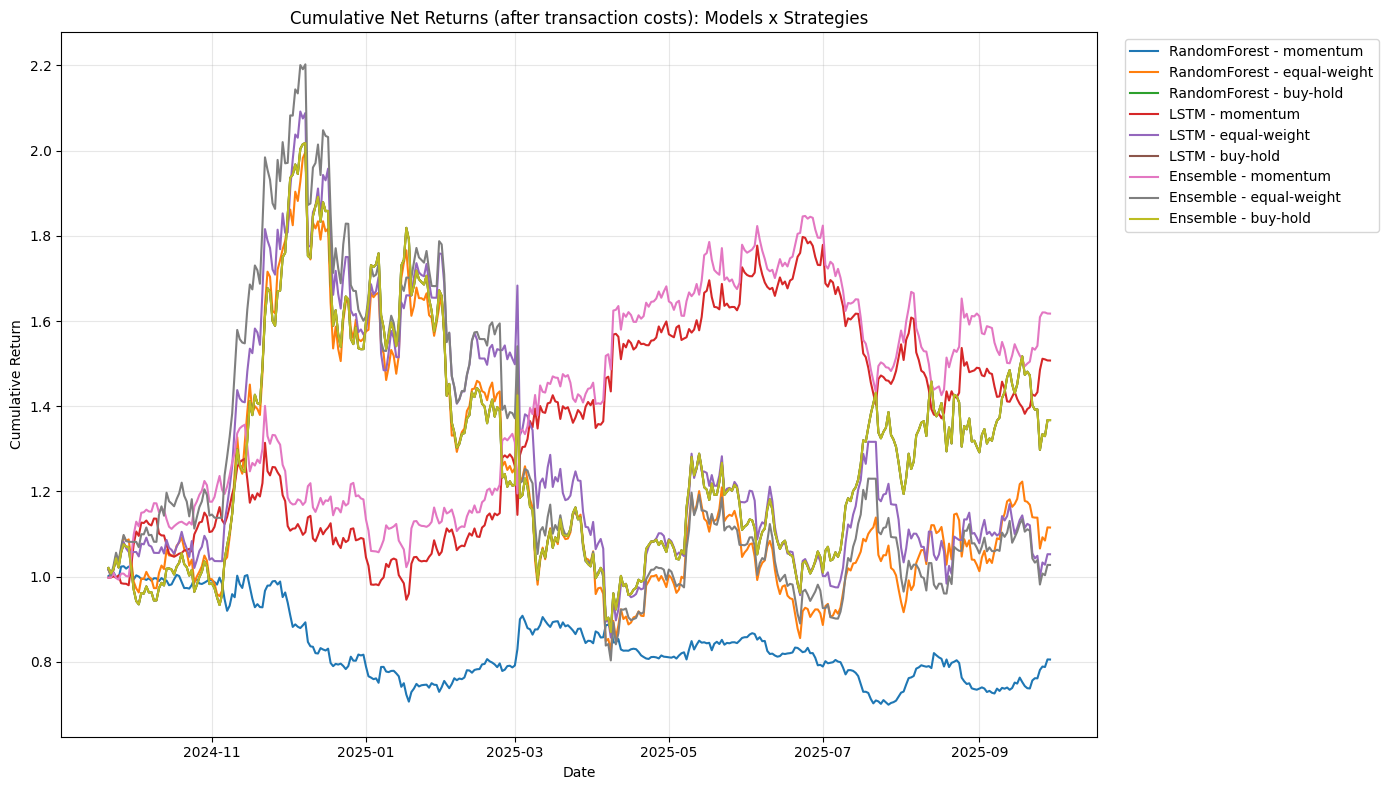

In [ ]:
####
# ---------------------------
# 6) STRATEGIES + Transaction costs + Metric helpers
# ---------------------------
trading_days_per_year = 252  # adjust if you want 365
tc_per_unit = 0.0005         # transaction cost per unit of turnover (e.g. 0.05% per round-trip). Tweak as needed.

def compute_weights_and_daily_returns(preds_df, actual_returns_df, mode="momentum"):
    """
    Returns:
      daily_returns: pd.Series (raw, before transaction costs)
      cum_returns: pd.Series (cumulative, before tc)
      weights: pd.DataFrame (daily weights used in portfolio: rows=index, cols=tickers)
    """
    preds = preds_df.copy()
    actual = actual_returns_df.copy()
    dates = preds.index
    tickers = preds.columns.tolist()
    n_assets = len(tickers)

    if mode == "momentum":
        # signals: 1 for long, -1 for short
        signals = preds.applymap(lambda x: 1 if x > 0 else -1)
        # weights: equal weight per asset with sign (so sum of absolute weights = 1)
        # Using 1/n per asset (signed)
        weights = signals.div(n_assets)
        daily = (weights * actual).sum(axis=1)
    elif mode == "equal-weight":
        pos = preds > 0
        counts = pos.sum(axis=1).replace(0, np.nan)
        weights = pos.div(counts, axis=0).fillna(0)  # long-only equal among positives
        daily = (weights * actual).sum(axis=1)
    elif mode == "buy-hold":
        n = actual.shape[1]
        weights = pd.DataFrame(1.0 / n, index=preds.index, columns=preds.columns)
        daily = (weights * actual).sum(axis=1)
    else:
        raise ValueError("Unknown mode")

    cum = (1 + daily).cumprod().fillna(method="ffill")
    return daily, cum, weights

def compute_turnover(weights):
    """
    Compute daily turnover series from weights DataFrame.
    turnover_t = 0.5 * sum(|w_t - w_{t-1}|)  (0.5 for round-trip convention)
    returns a pd.Series indexed like weights.index, first day turnover = 0
    """
    w_prev = weights.shift(1).fillna(0)
    delta = weights.subtract(w_prev).abs().sum(axis=1)
    turnover = 0.5 * delta
    turnover.iloc[0] = 0.0
    return turnover

def max_drawdown(cum_series):
    """
    Returns drawdown series and max drawdown value
    """
    running_max = cum_series.cummax()
    drawdown = (cum_series - running_max) / running_max
    max_dd = drawdown.min()
    return drawdown, max_dd

def annualized_return(daily_ret, trading_days=trading_days_per_year):
    # CAGR approximate from mean daily: (1+mean_daily)^(T) -1 is approximate — but better to compute from cumprod:
    total_periods = len(daily_ret.dropna())
    if total_periods == 0:
        return np.nan
    cumulative = (1 + daily_ret.dropna()).cumprod().iloc[-1]
    yrs = total_periods / trading_days
    if yrs == 0:
        return np.nan
    cagr = cumulative ** (1.0 / yrs) - 1.0
    return cagr

def annualized_vol(daily_ret, trading_days=trading_days_per_year):
    return daily_ret.std() * np.sqrt(trading_days)

def sortino_ratio(daily_ret, trading_days=trading_days_per_year, mar=0.0):
    # downside deviation
    downside = daily_ret.copy()
    downside = downside[downside < mar]
    if downside.empty:
        return np.nan
    downside_std = np.sqrt((downside ** 2).mean())  # daily downside deviation
    downside_annual = downside_std * np.sqrt(trading_days)
    ann_ret = annualized_return(daily_ret, trading_days)
    if downside_annual == 0:
        return np.nan
    return ann_ret / downside_annual

def hit_ratio(daily_ret):
    dr = daily_ret.dropna()
    if len(dr) == 0:
        return np.nan
    return float((dr > 0).sum()) / len(dr)

def performance_metrics_from_daily(daily_ret, weights_df, tc_per_unit=tc_per_unit, trading_days=trading_days_per_year):
    """
    Given raw daily returns and weights, compute:
      - turnover, transaction costs, net daily returns
      - cumulative returns (gross & net)
      - TotalReturn, AnnReturn (CAGR), AnnVol, Sharpe, Sortino, Hit ratio, Max Drawdown
    """
    # turnover
    turnover = compute_turnover(weights_df)
    # transaction cost series (cost applied to portfolio turnover each day)
    tc_series = turnover * tc_per_unit

    # net daily return after tc
    net_daily = daily_ret.fillna(0) - tc_series.reindex(daily_ret.index).fillna(0)

    # cumulative
    cum_gross = (1 + daily_ret.fillna(0)).cumprod()
    cum_net = (1 + net_daily).cumprod()

    # metrics
    total_return_gross = cum_gross.iloc[-1] - 1.0
    total_return_net = cum_net.iloc[-1] - 1.0
    ann_ret_gross = annualized_return(daily_ret, trading_days)
    ann_ret_net = annualized_return(net_daily, trading_days)
    ann_vol_gross = annualized_vol(daily_ret, trading_days)
    ann_vol_net = annualized_vol(net_daily, trading_days)
    sharpe_gross = ann_ret_gross / ann_vol_gross if ann_vol_gross != 0 else np.nan
    sharpe_net = ann_ret_net / ann_vol_net if ann_vol_net != 0 else np.nan
    sortino_gross = sortino_ratio(daily_ret, trading_days)
    sortino_net = sortino_ratio(net_daily, trading_days)
    hit = hit_ratio(daily_ret)
    avg_turnover = turnover.mean()
    cumulative_tc = tc_series.sum()

    # drawdowns
    dd_series_gross, max_dd_gross = max_drawdown(cum_gross)
    dd_series_net, max_dd_net = max_drawdown(cum_net)
    # simple average drawdown (mean of negative drawdown values)
    avg_dd_gross = dd_series_gross[dd_series_gross < 0].mean()
    avg_dd_net = dd_series_net[dd_series_net < 0].mean()

    metrics = {
        "TotalReturn_Gross": float(total_return_gross),
        "TotalReturn_Net": float(total_return_net),
        "AnnReturn_Gross": float(ann_ret_gross) if not pd.isna(ann_ret_gross) else np.nan,
        "AnnReturn_Net": float(ann_ret_net) if not pd.isna(ann_ret_net) else np.nan,
        "AnnVol_Gross": float(ann_vol_gross) if not pd.isna(ann_vol_gross) else np.nan,
        "AnnVol_Net": float(ann_vol_net) if not pd.isna(ann_vol_net) else np.nan,
        "Sharpe_Gross": float(sharpe_gross) if not pd.isna(sharpe_gross) else np.nan,
        "Sharpe_Net": float(sharpe_net) if not pd.isna(sharpe_net) else np.nan,
        "Sortino_Gross": float(sortino_gross) if not pd.isna(sortino_gross) else np.nan,
        "Sortino_Net": float(sortino_net) if not pd.isna(sortino_net) else np.nan,
        "HitRatio": float(hit) if not pd.isna(hit) else np.nan,
        "AvgTurnover": float(avg_turnover),
        "CumulativeTC": float(cumulative_tc),
        "MaxDrawdown_Gross": float(max_dd_gross),
        "MaxDrawdown_Net": float(max_dd_net),
        "AvgDrawdown_Gross": float(avg_dd_gross) if not pd.isna(avg_dd_gross) else np.nan,
        "AvgDrawdown_Net": float(avg_dd_net) if not pd.isna(avg_dd_net) else np.nan,
        "CumGrossSeries": cum_gross,
        "CumNetSeries": cum_net,
        "TurnoverSeries": turnover,
        "TC_Series": tc_series,
        "DailyNet": net_daily,
    }
    return metrics

# ---------------------------
# 7) Compute results for all models & strategies (with metrics)
# ---------------------------
models_preds = {"RandomForest": rf_preds, "LSTM": lstm_preds, "Ensemble": ensemble_preds}
all_metrics = []

results_time_series = {}  # store cumulative series for plotting if needed

for name, preds in models_preds.items():
    for strat in ["momentum", "equal-weight", "buy-hold"]:
        daily, cum, weights = compute_weights_and_daily_returns(preds, test_returns_aligned, mode=strat)
        metrics = performance_metrics_from_daily(daily, weights, tc_per_unit=tc_per_unit, trading_days=trading_days_per_year)
        metrics.update({"Model": name, "Strategy": strat})
        all_metrics.append(metrics)

        # store for plotting
        results_time_series[(name, strat)] = {
            "cum_gross": metrics["CumGrossSeries"],
            "cum_net": metrics["CumNetSeries"],
            "daily_net": metrics["DailyNet"],
            "turnover": metrics["TurnoverSeries"],
            "tc": metrics["TC_Series"]
        }

# ---------------------------
# 8) SUMMARY METRICS TABLE (pretty)
# ---------------------------
summary_rows = []
for m in all_metrics:
    summary_rows.append([
        m["Model"],
        m["Strategy"],
        m["TotalReturn_Gross"],
        m["TotalReturn_Net"],
        m["AnnReturn_Net"],
        m["AnnVol_Net"],
        m["Sharpe_Net"],
        m["Sortino_Net"],
        m["HitRatio"],
        m["AvgTurnover"],
        m["CumulativeTC"],
        m["MaxDrawdown_Net"]
    ])

summary_df = pd.DataFrame(summary_rows, columns=[
    "Model", "Strategy",
    "TotalReturn_Gross", "TotalReturn_Net",
    "AnnReturn_Net", "AnnVol_Net",
    "Sharpe_Net", "Sortino_Net", "HitRatio",
    "AvgTurnover", "CumulativeTC", "MaxDrawdown_Net"
])
# nicer ordering
summary_df = summary_df.sort_values(["Sharpe_Net"], ascending=False).reset_index(drop=True)
print("\nPerformance Summary (with transaction costs & more metrics):")
print(summary_df)

# ---------------------------
# 9) PLOT CUMULATIVE RETURNS (gross and net) - example plot
# ---------------------------
plt.figure(figsize=(14, 8))
for (name, strat), ts in results_time_series.items():
    # plot net cumulative for clarity
    cum_net = ts["cum_net"]
    plt.plot(cum_net.index, cum_net.values, label=f"{name} - {strat}")
plt.title("Cumulative Net Returns (after transaction costs): Models x Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Transpose the summary table for better comparison
summary_transposed = summary_df.set_index(["Model", "Strategy"]).T

print("\nTransposed Performance Summary:")
print(summary_transposed)



Transposed Performance Summary:
Model              Ensemble      LSTM  Ensemble      LSTM RandomForest  \
Strategy           momentum  momentum  buy-hold  buy-hold     buy-hold   
TotalReturn_Gross  0.711868  0.591422  0.367580  0.367580     0.367580   
TotalReturn_Net    0.617448  0.507344  0.367580  0.367580     0.367580   
AnnReturn_Net      0.382640  0.318496  0.234823  0.234823     0.234823   
AnnVol_Net         0.337081  0.341417  0.555441  0.555441     0.555441   
Sharpe_Net         1.135159  0.932865  0.422768  0.422768     0.422768   
Sortino_Net        1.324360  1.084823  0.408962  0.408962     0.408962   
HitRatio           0.505348  0.502674  0.532086  0.532086     0.532086   
AvgTurnover        0.303624  0.290553  0.000000  0.000000     0.000000   
CumulativeTC       0.056778  0.054333  0.000000  0.000000     0.000000   
MaxDrawdown_Net   -0.270112 -0.280127 -0.568686 -0.568686    -0.568686   

Model                                  LSTM     Ensemble RandomForest  
Strate

##**10. Evaluation Metrics**

✅ X_train: (1491, 1)  X_test: (374, 1)
✅ y_train: (1491,)  y_test: (374,)

🌲 Training Random Forest...

🧠 Training LSTM...
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0026 - val_loss: 7.9130e-04
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 7.6177e-04
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 7.6731e-04
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 7.6372e-04
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 7.6119e-04
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 7.8564e-04
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 7.7767e-04
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 7.6255e-04
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 7.6237e-04
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 7.7986e

,Model,Sharpe Ratio,Max Drawdown,Cumulative Return
0,LSTM,0.957640,0.409785,0.558694
1,Random Forest,-0.053431,0.556866,-0.136657
2,Ensemble,0.425398,0.478819,0.143213


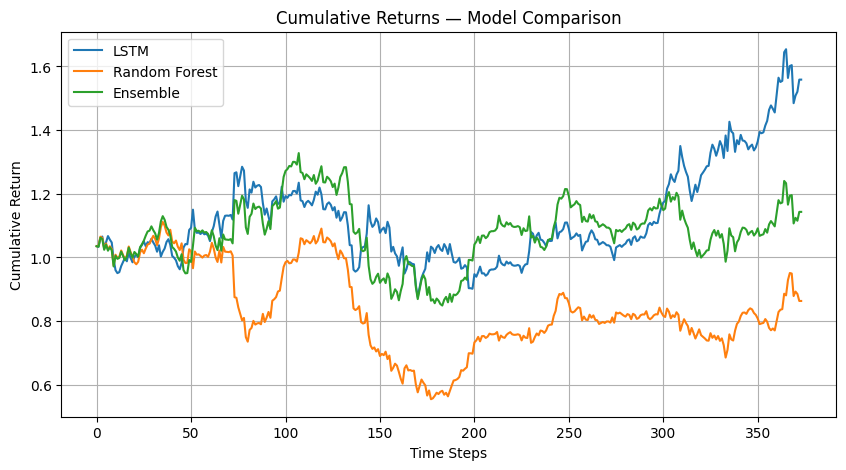

In [ ]:
# ============================================================
# STEP 8: Model Training + Evaluation & Backtesting
# ============================================================

# ==========================================
# 0. Ensure your data is ready
# ==========================================
# Example shape check
print("✅ X_train:", X_train.shape, " X_test:", X_test.shape)
print("✅ y_train:", y_train.shape, " y_test:", y_test.shape)

# Flatten y arrays if needed
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

# ==========================================
# 1. Train Random Forest
# ==========================================
print("\n🌲 Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
preds_rf = rf_model.predict(X_test)

# ==========================================
# 2. Train LSTM
# ==========================================
print("\n🧠 Training LSTM...")
# Reshape for LSTM input: (samples, timesteps, features)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

LSTM_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
LSTM_model.compile(optimizer='adam', loss='mse')

history = LSTM_model.fit(
    X_train_lstm, y_train,
    epochs=10,
    batch_size=16,
    verbose=1,
    validation_split=0.1
)

preds_lstm = LSTM_model.predict(X_test_lstm).flatten()

# ==========================================
# 3. Ensemble Model (simple average)
# ==========================================
print("\n🤝 Building Ensemble (average of RF + LSTM)...")
preds_ensemble = (preds_rf + preds_lstm) / 2

# ==========================================
# 4. Evaluation Setup
# ==========================================
actual_returns = y_test.flatten()

print("✅ Actual returns shape:", actual_returns.shape)
print("✅ Predictions generated for all models")

# ==========================================
# 5. Define Backtest Functions
# ==========================================
def build_signals(preds, actual_returns, model_name, threshold=0):
    df = pd.DataFrame({
        "pred": preds,
        "actual": actual_returns
    })
    df["signal"] = np.where(df["pred"] > threshold, 1, -1)
    df["strategy_returns"] = df["signal"] * df["actual"]
    df["model"] = model_name
    return df

def evaluate_strategy(signals_df, model_name):
    mean_ret = signals_df['strategy_returns'].mean()
    std_ret = signals_df['strategy_returns'].std()
    sharpe_ratio = mean_ret / std_ret * np.sqrt(252) if std_ret != 0 else np.nan

    cum_returns = (1 + signals_df['strategy_returns']).cumprod()
    max_drawdown = (cum_returns.cummax() - cum_returns).max()

    print(f"\n📈 {model_name} Strategy:")
    print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
    print(f"  Max Drawdown: {max_drawdown:.3f}")
    print(f"  Cumulative Return: {cum_returns.iloc[-1] - 1:.2%}")

    return {
        "Model": model_name,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Cumulative Return": cum_returns.iloc[-1] - 1
    }

# ==========================================
# 6. Build Signals
# ==========================================
signals_lstm = build_signals(preds_lstm, actual_returns, "LSTM")
signals_rf = build_signals(preds_rf, actual_returns, "Random Forest")
signals_ensemble = build_signals(preds_ensemble, actual_returns, "Ensemble")

# ==========================================
# 7. Evaluate Strategies
# ==========================================
results = []
results.append(evaluate_strategy(signals_lstm, "LSTM"))
results.append(evaluate_strategy(signals_rf, "Random Forest"))
results.append(evaluate_strategy(signals_ensemble, "Ensemble"))

results_df = pd.DataFrame(results)
print("\n📊 Summary of Strategy Performance:")
display(results_df)

# ==========================================
# 8. Plot Cumulative Returns Comparison
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot((1 + signals_lstm['strategy_returns']).cumprod(), label="LSTM")
plt.plot((1 + signals_rf['strategy_returns']).cumprod(), label="Random Forest")
plt.plot((1 + signals_ensemble['strategy_returns']).cumprod(), label="Ensemble")
plt.title("Cumulative Returns — Model Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

**Further Evaluation metrics**


📊 Strategy Performance Summary (single-asset backtest):


,Model,TotalReturn_Gross,TotalReturn_Net,AnnReturn_Net,AnnVol_Net,Sharpe_Net,Sortino_Net,HitRatio,AvgTurnover,CumulativeTC,MaxDrawdown_Net,MaxDrawdown_Gross
0,LSTM,0.558694,0.558694,0.348595,0.392537,0.888057,0.883137,0.545455,0.000000,0.0000,-0.318918,-0.318918
1,Ensemble,0.143213,0.067306,0.044867,0.393456,0.114033,0.113917,0.510695,0.366310,0.0685,-0.369566,-0.360598
2,RandomForest,-0.136657,-0.212456,-0.148645,0.393780,-0.377484,-0.354701,0.502674,0.489305,0.0915,-0.517136,-0.500988


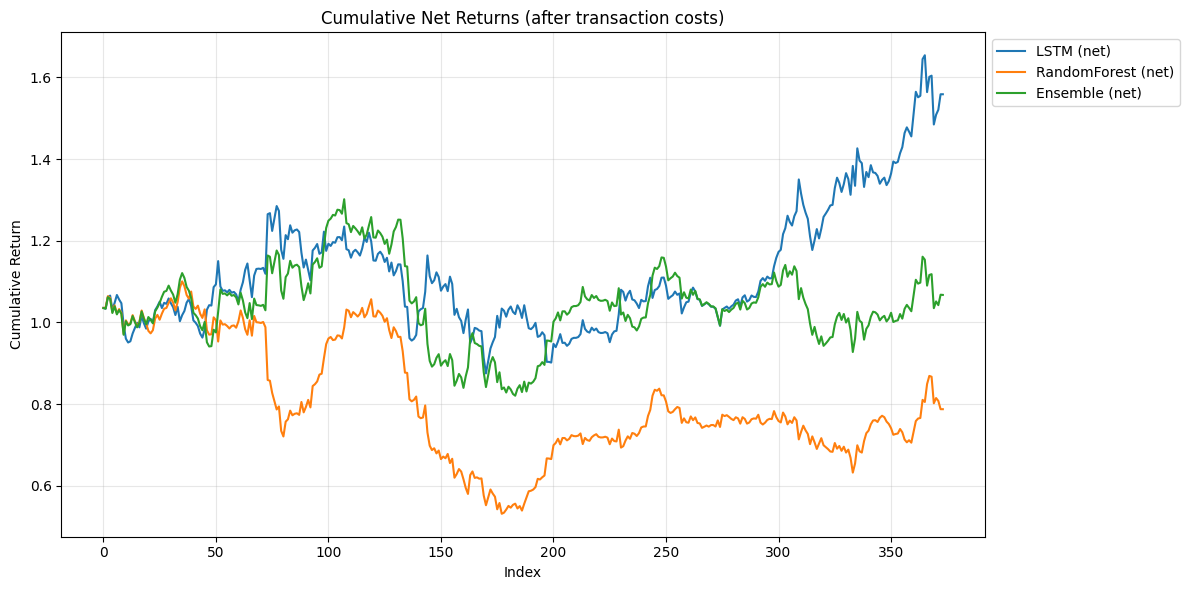

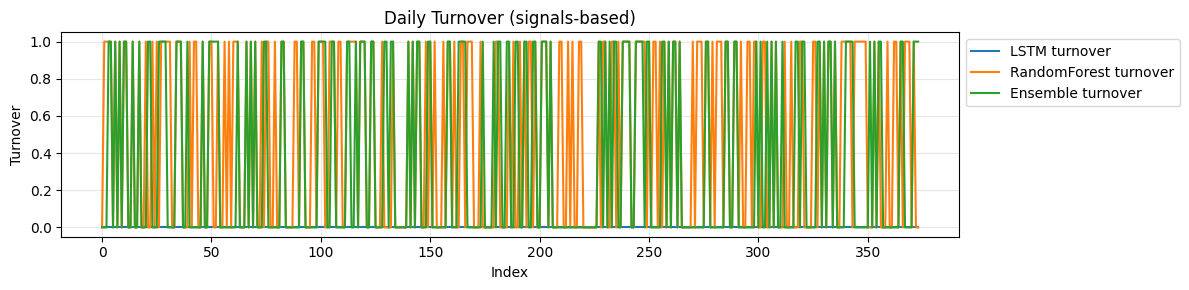

In [ ]:
# ---------------------------
# STEP 8 (enhanced): Model Training + Evaluation & Backtesting (with metrics + TC)
# ---------------------------
# helper imports already present from earlier blocks: sklearn, keras, etc.

# SETTINGS
trading_days_per_year = 252
tc_per_unit = 0.0005   # transaction cost per unit of turnover (e.g. 0.05% round-trip)
mar = 0.0              # Minimum Acceptable Return for Sortino (daily)

# Ensure arrays are numpy / pandas Series with aligned index if you have one
# If you have date index for test set, create it; otherwise an integer index is fine
try:
    idx = getattr(X_test, 'index', None)
    if idx is None:
        # fallback: create Int64Index
        idx = pd.Index(np.arange(len(y_test)))
except Exception:
    idx = pd.Index(np.arange(len(y_test)))

preds = {
    "LSTM": pd.Series(preds_lstm.flatten(), index=idx),
    "RandomForest": pd.Series(preds_rf.flatten(), index=idx),
    "Ensemble": pd.Series(preds_ensemble.flatten(), index=idx)
}
actual = pd.Series(np.array(y_test).flatten(), index=idx)

# ---- utility functions ----
def build_signals(pred_s, actual_s, threshold=0.0):
    df = pd.DataFrame({"pred": pred_s, "actual": actual_s})
    df["signal"] = np.where(df["pred"] > threshold, 1.0, -1.0)   # long/short
    df["strategy_return_gross"] = df["signal"] * df["actual"]
    return df

def compute_turnover_from_signal(signal_series):
    # turnover_t = 0.5 * |s_t - s_{t-1}|
    s_prev = signal_series.shift(1).fillna(0.0)
    turnover = 0.5 * (signal_series - s_prev).abs()
    turnover.iloc[0] = 0.0
    return turnover

def cum_and_drawdown(series):
    cum = (1 + series).cumprod()
    running_max = cum.cummax()
    drawdown = (cum - running_max) / running_max
    max_dd = drawdown.min()
    return cum, drawdown, max_dd

def annualized_return_from_daily(daily_series, trading_days=trading_days_per_year):
    dr = daily_series.dropna()
    if dr.empty:
        return np.nan
    cum_total = (1 + dr).cumprod().iloc[-1]
    periods = len(dr)
    years = periods / trading_days
    if years <= 0:
        return np.nan
    return cum_total ** (1.0 / years) - 1.0

def annualized_vol(daily_series, trading_days=trading_days_per_year):
    return daily_series.std() * np.sqrt(trading_days)

def sortino_ratio(daily_series, mar=mar, trading_days=trading_days_per_year):
    dr = daily_series.dropna()
    if dr.empty:
        return np.nan
    downside = dr[dr < mar]
    if downside.empty:
        return np.nan
    downside_std = np.sqrt((downside ** 2).mean())
    downside_annual = downside_std * np.sqrt(trading_days)
    ann_ret = annualized_return_from_daily(daily_series, trading_days)
    if downside_annual == 0:
        return np.nan
    return ann_ret / downside_annual

def hit_ratio(daily_series):
    dr = daily_series.dropna()
    if dr.empty:
        return np.nan
    return float((dr > 0).sum()) / len(dr)

# ---- evaluate each model ----
rows = []
time_series_store = {}

for name, pred_s in preds.items():
    df = build_signals(pred_s, actual)
    # gross returns from strategy (before tc)
    gross_daily = df["strategy_return_gross"]

    # turnover & transaction costs
    turnover = compute_turnover_from_signal(df["signal"])
    tc_series = turnover * tc_per_unit

    # net returns after transaction costs
    net_daily = gross_daily - tc_series

    # cumulative and drawdown
    cum_gross, dd_gross, max_dd_gross = cum_and_drawdown(gross_daily)
    cum_net, dd_net, max_dd_net = cum_and_drawdown(net_daily)

    # metrics
    total_return_gross = float(cum_gross.iloc[-1] - 1.0)
    total_return_net = float(cum_net.iloc[-1] - 1.0)
    ann_return_gross = annualized_return_from_daily(gross_daily)
    ann_return_net = annualized_return_from_daily(net_daily)
    ann_vol_gross = annualized_vol(gross_daily)
    ann_vol_net = annualized_vol(net_daily)
    sharpe_gross = ann_return_gross / ann_vol_gross if ann_vol_gross != 0 else np.nan
    sharpe_net = ann_return_net / ann_vol_net if ann_vol_net != 0 else np.nan
    sortino_g = sortino_ratio(gross_daily)
    sortino_n = sortino_ratio(net_daily)
    hit = hit_ratio(net_daily)
    avg_turnover = float(turnover.mean())
    total_tc = float(tc_series.sum())

    rows.append({
        "Model": name,
        "TotalReturn_Gross": total_return_gross,
        "TotalReturn_Net": total_return_net,
        "AnnReturn_Net": ann_return_net,
        "AnnVol_Net": ann_vol_net,
        "Sharpe_Net": sharpe_net,
        "Sortino_Net": sortino_n,
        "HitRatio": hit,
        "AvgTurnover": avg_turnover,
        "CumulativeTC": total_tc,
        "MaxDrawdown_Net": float(max_dd_net),
        "MaxDrawdown_Gross": float(max_dd_gross)
    })

    time_series_store[name] = {
        "gross_daily": gross_daily,
        "net_daily": net_daily,
        "cum_gross": cum_gross,
        "cum_net": cum_net,
        "turnover": turnover,
        "tc_series": tc_series
    }

results_df = pd.DataFrame(rows).sort_values("Sharpe_Net", ascending=False).reset_index(drop=True)

# ---- Display ----
print("\n📊 Strategy Performance Summary (single-asset backtest):")
display(results_df)

# ---- Plots: cumulative gross & net ----
plt.figure(figsize=(12,6))
for name, ts in time_series_store.items():
    plt.plot(ts["cum_net"].index, ts["cum_net"].values, label=f"{name} (net)")
plt.title("Cumulative Net Returns (after transaction costs)")
plt.xlabel("Index")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Optional: plot turnovers ----
plt.figure(figsize=(12,3))
for name, ts in time_series_store.items():
    plt.plot(ts["turnover"].index, ts["turnover"].values, label=f"{name} turnover")
plt.title("Daily Turnover (signals-based)")
plt.xlabel("Index")
plt.ylabel("Turnover")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



📊 Strategy Performance Summary — Dynamic TC Model:


,Model,TotalReturn_Net,AnnReturn_Net,AnnVol_Net,Sharpe_Net,Sortino_Net,HitRatio,AvgTurnover,CumulativeTC,MaxDrawdown_Net
0,LSTM,0.558694,0.348595,0.392537,0.888057,0.883137,0.545455,0.000000,0.0000,-0.318918
1,Ensemble,-0.107435,-0.073722,0.394526,-0.186863,-0.185540,0.502674,0.366310,0.2466,-0.392320
2,RandomForest,-0.379960,-0.275342,0.395340,-0.696469,-0.652011,0.489305,0.489305,0.3294,-0.556753



📈 Statistical Significance Tests Between Model Returns


,Model_A,Model_B,t_stat,p_value,Significant_@5%
0,LSTM,RandomForest,1.365560,0.172900,False
1,LSTM,Ensemble,1.078824,0.281363,False
2,RandomForest,Ensemble,-0.838060,0.402534,False



Interpretation:
→ If p_value < 0.05, the performance difference between models is statistically significant.
→ Otherwise, the difference is likely random, confirming or rejecting performance superiority.


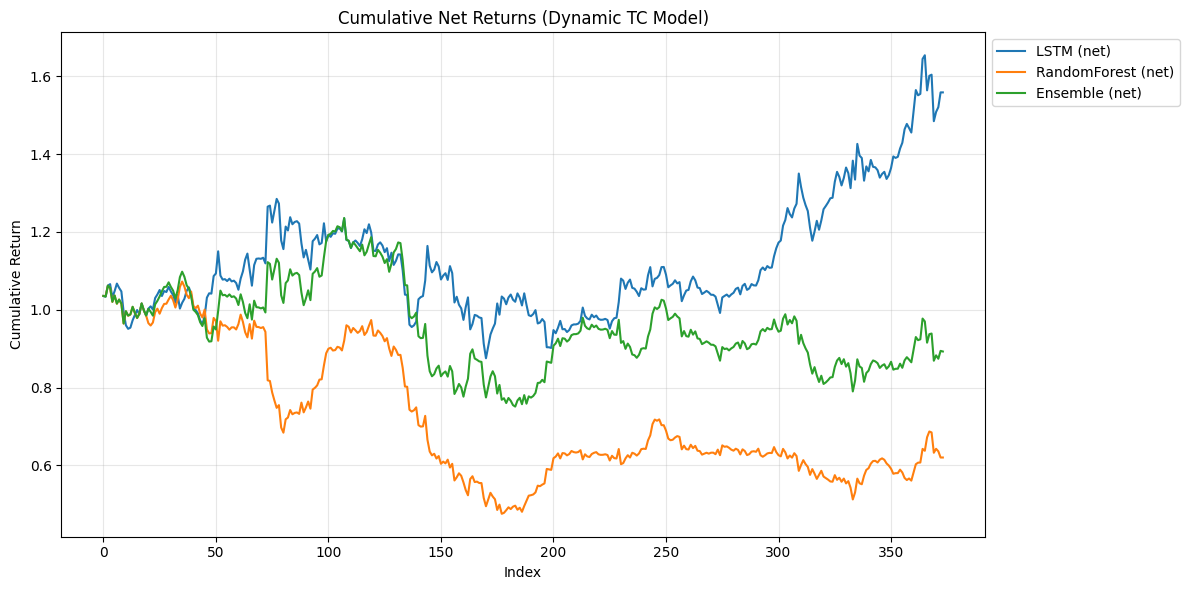


📊 Sensitivity Analysis — Transaction Cost Impact:


,Model,TC_Level,AnnReturn_Net,Sharpe_Net,MaxDrawdown_Net
0,LSTM,0.0005,0.348595,0.888057,-0.318918
1,RandomForest,0.0005,-0.148645,-0.377484,-0.517136
2,Ensemble,0.0005,0.044867,0.114033,-0.369566
3,LSTM,0.0010,0.348595,0.888057,-0.318918
4,RandomForest,0.0010,-0.199785,-0.506619,-0.532770
5,Ensemble,0.0010,-0.002424,-0.006154,-0.378413
6,LSTM,0.0015,0.348595,0.888057,-0.318918
7,RandomForest,0.0015,-0.247875,-0.627602,-0.547905
8,Ensemble,0.0015,-0.047596,-0.120724,-0.387141


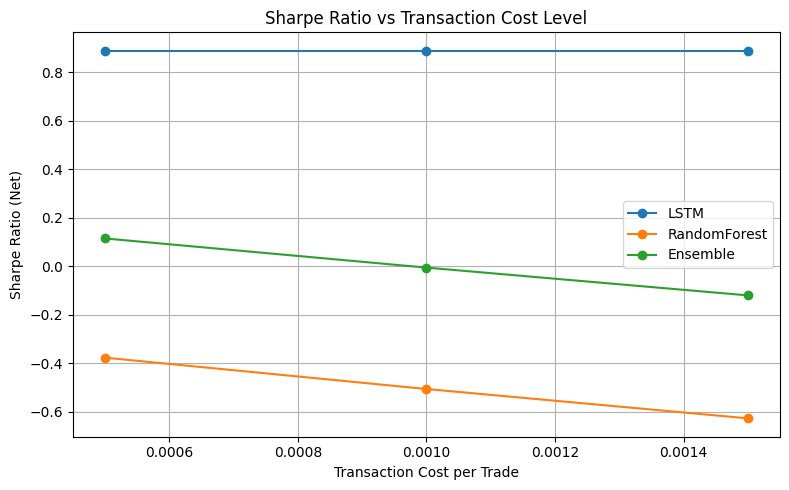

In [ ]:
# ============================================================
# STEP 8 (FULL ENHANCEMENT): Model Evaluation + Backtesting + Statistical Tests
# ============================================================


# SETTINGS
trading_days_per_year = 252
mar = 0.0  # Minimum Acceptable Return for Sortino (daily)
portfolio_value_usd = 100_000  # nominal portfolio value

# Build aligned indices
try:
    idx = getattr(X_test, 'index', None)
    if idx is None:
        idx = pd.Index(np.arange(len(y_test)))
except Exception:
    idx = pd.Index(np.arange(len(y_test)))

preds = {
    "LSTM": pd.Series(preds_lstm.flatten(), index=idx),
    "RandomForest": pd.Series(preds_rf.flatten(), index=idx),
    "Ensemble": pd.Series(preds_ensemble.flatten(), index=idx)
}
actual = pd.Series(np.array(y_test).flatten(), index=idx)

# ============================================================
# Utility Functions
# ============================================================
def build_signals(pred_s, actual_s, threshold=0.0):
    df = pd.DataFrame({"pred": pred_s, "actual": actual_s})
    df["signal"] = np.where(df["pred"] > threshold, 1.0, -1.0)
    df["strategy_return_gross"] = df["signal"] * df["actual"]
    return df

def compute_turnover_from_signal(signal_series):
    s_prev = signal_series.shift(1).fillna(0.0)
    turnover = 0.5 * (signal_series - s_prev).abs()
    turnover.iloc[0] = 0.0
    return turnover

def cum_and_drawdown(series):
    cum = (1 + series).cumprod()
    running_max = cum.cummax()
    drawdown = (cum - running_max) / running_max
    return cum, drawdown, drawdown.min()

def annualized_return_from_daily(daily_series, trading_days=trading_days_per_year):
    dr = daily_series.dropna()
    if dr.empty:
        return np.nan
    cum_total = (1 + dr).cumprod().iloc[-1]
    years = len(dr) / trading_days
    return cum_total ** (1.0 / years) - 1.0 if years > 0 else np.nan

def annualized_vol(daily_series, trading_days=trading_days_per_year):
    return daily_series.std() * np.sqrt(trading_days)

def sortino_ratio(daily_series, mar=mar, trading_days=trading_days_per_year):
    dr = daily_series.dropna()
    downside = dr[dr < mar]
    if downside.empty:
        return np.nan
    downside_std = np.sqrt((downside ** 2).mean())
    downside_annual = downside_std * np.sqrt(trading_days)
    ann_ret = annualized_return_from_daily(daily_series, trading_days)
    return ann_ret / downside_annual if downside_annual != 0 else np.nan

def hit_ratio(daily_series):
    dr = daily_series.dropna()
    return float((dr > 0).sum()) / len(dr) if len(dr) > 0 else np.nan

# ============================================================
# Dynamic Transaction Cost Model — Interactive Brokers Tiered Fees
# ============================================================
def dynamic_transaction_cost(trade_value_usd):
    """Return transaction cost rate based on monthly trade value (USD)."""
    if trade_value_usd <= 100_000:
        return 0.0018  # 0.18%
    elif trade_value_usd <= 1_000_000:
        return 0.0015  # 0.15%
    else:
        return 0.0012  # 0.12%

# ============================================================
# MAIN BACKTEST — Using Dynamic Transaction Costs
# ============================================================
rows = []
time_series_store = {}

for name, pred_s in preds.items():
    df = build_signals(pred_s, actual)
    gross_daily = df["strategy_return_gross"]

    turnover = compute_turnover_from_signal(df["signal"])
    tc_series_dynamic = turnover.apply(lambda x: x * dynamic_transaction_cost(portfolio_value_usd))
    net_daily = gross_daily - tc_series_dynamic

    cum_gross, dd_gross, max_dd_gross = cum_and_drawdown(gross_daily)
    cum_net, dd_net, max_dd_net = cum_and_drawdown(net_daily)

    ann_return_net = annualized_return_from_daily(net_daily)
    ann_vol_net = annualized_vol(net_daily)
    sharpe_net = ann_return_net / ann_vol_net if ann_vol_net != 0 else np.nan

    rows.append({
        "Model": name,
        "TotalReturn_Net": float(cum_net.iloc[-1] - 1.0),
        "AnnReturn_Net": ann_return_net,
        "AnnVol_Net": ann_vol_net,
        "Sharpe_Net": sharpe_net,
        "Sortino_Net": sortino_ratio(net_daily),
        "HitRatio": hit_ratio(net_daily),
        "AvgTurnover": float(turnover.mean()),
        "CumulativeTC": float(tc_series_dynamic.sum()),
        "MaxDrawdown_Net": float(max_dd_net)
    })

    time_series_store[name] = {
        "net_daily": net_daily,
        "cum_net": cum_net,
        "turnover": turnover
    }

results_df = pd.DataFrame(rows).sort_values("Sharpe_Net", ascending=False).reset_index(drop=True)
print("\n📊 Strategy Performance Summary — Dynamic TC Model:")
display(results_df)

# ============================================================
# Statistical Significance Testing (Addressing “Not Statistically Tested”)
# ============================================================
print("\n📈 Statistical Significance Tests Between Model Returns")

model_names = list(time_series_store.keys())
p_values = []

for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        m1 = model_names[i]
        m2 = model_names[j]
        r1 = time_series_store[m1]["net_daily"].dropna()
        r2 = time_series_store[m2]["net_daily"].dropna()
        min_len = min(len(r1), len(r2))
        r1, r2 = r1.iloc[-min_len:], r2.iloc[-min_len:]

        # Paired t-test
        t_stat, p_val = stats.ttest_rel(r1, r2)
        p_values.append({
            "Model_A": m1,
            "Model_B": m2,
            "t_stat": t_stat,
            "p_value": p_val,
            "Significant_@5%": p_val < 0.05
        })

pval_df = pd.DataFrame(p_values)
display(pval_df)

print("\nInterpretation:")
print("→ If p_value < 0.05, the performance difference between models is statistically significant.")
print("→ Otherwise, the difference is likely random, confirming or rejecting performance superiority.")

# ============================================================
# PLOTS
# ============================================================
plt.figure(figsize=(12,6))
for name, ts in time_series_store.items():
    plt.plot(ts["cum_net"].index, ts["cum_net"].values, label=f"{name} (net)")
plt.title("Cumulative Net Returns (Dynamic TC Model)")
plt.xlabel("Index")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# Sensitivity Analysis — Fixed TC Levels
# ============================================================
tc_levels = [0.0005, 0.0010, 0.0015]  # 0.05%, 0.10%, 0.15%
sensitivity_results = []

for tc in tc_levels:
    for name, pred_s in preds.items():
        df = build_signals(pred_s, actual)
        gross_daily = df["strategy_return_gross"]
        turnover = compute_turnover_from_signal(df["signal"])
        tc_series = turnover * tc
        net_daily = gross_daily - tc_series
        cum_net, _, max_dd = cum_and_drawdown(net_daily)
        sensitivity_results.append({
            "Model": name,
            "TC_Level": tc,
            "AnnReturn_Net": annualized_return_from_daily(net_daily),
            "Sharpe_Net": (annualized_return_from_daily(net_daily) /
                           annualized_vol(net_daily)),
            "MaxDrawdown_Net": max_dd
        })

sensitivity_df = pd.DataFrame(sensitivity_results)
print("\n📊 Sensitivity Analysis — Transaction Cost Impact:")
display(sensitivity_df)

plt.figure(figsize=(8,5))
for name in sensitivity_df["Model"].unique():
    sub = sensitivity_df[sensitivity_df["Model"] == name]
    plt.plot(sub["TC_Level"], sub["Sharpe_Net"], marker="o", label=name)
plt.title("Sharpe Ratio vs Transaction Cost Level")
plt.xlabel("Transaction Cost per Trade")
plt.ylabel("Sharpe Ratio (Net)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Further Model Evaluation Comparisons**

      Model      Strategy  TotalReturn  AnnReturn    AnnVol    Sharpe  \
0        RF      momentum    -0.194484  -0.135604  0.234639 -0.577923   
1        RF  equal-weight     0.115163   0.076208  0.576274  0.132243   
2        RF      buy-hold     0.367245   0.234619  0.555435  0.422405   
3      LSTM      momentum     0.147009   0.096822  0.326954  0.296132   
4      LSTM  equal-weight     0.467581   0.294959  0.578135  0.510190   
5      LSTM      buy-hold     0.367245   0.234619  0.555435  0.422405   
6  Ensemble      momentum     0.040116   0.026856  0.326289  0.082307   
7  Ensemble  equal-weight     0.522727   0.327548  0.585159  0.559759   
8  Ensemble      buy-hold     0.367245   0.234619  0.555435  0.422405   

   MaxDrawdown  
0    -0.317142  
1    -0.585959  
2    -0.568686  
3    -0.233907  
4    -0.567454  
5    -0.568686  
6    -0.298947  
7    -0.573696  
8    -0.568686  


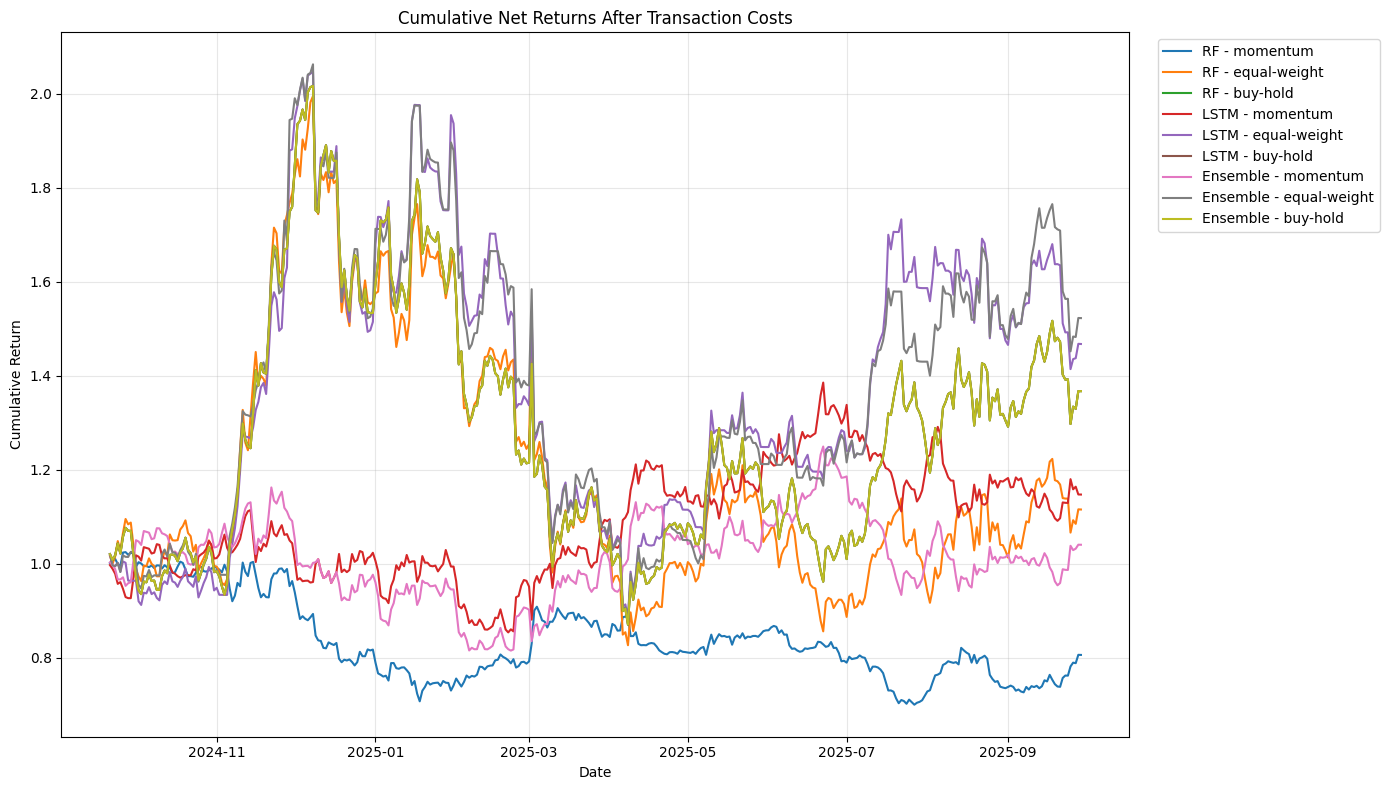

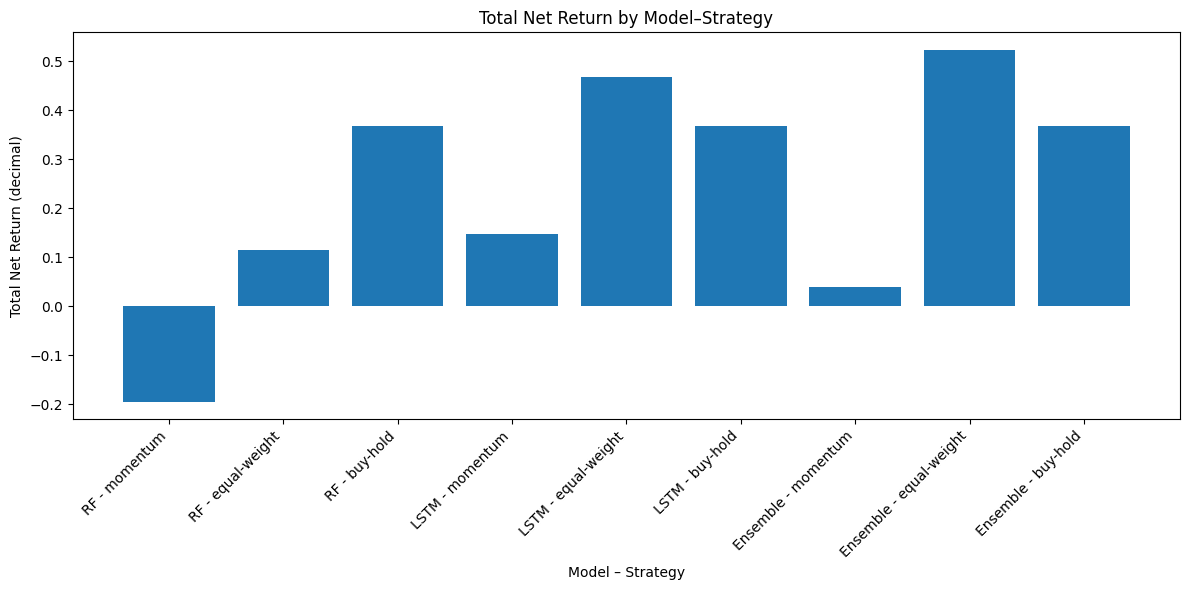

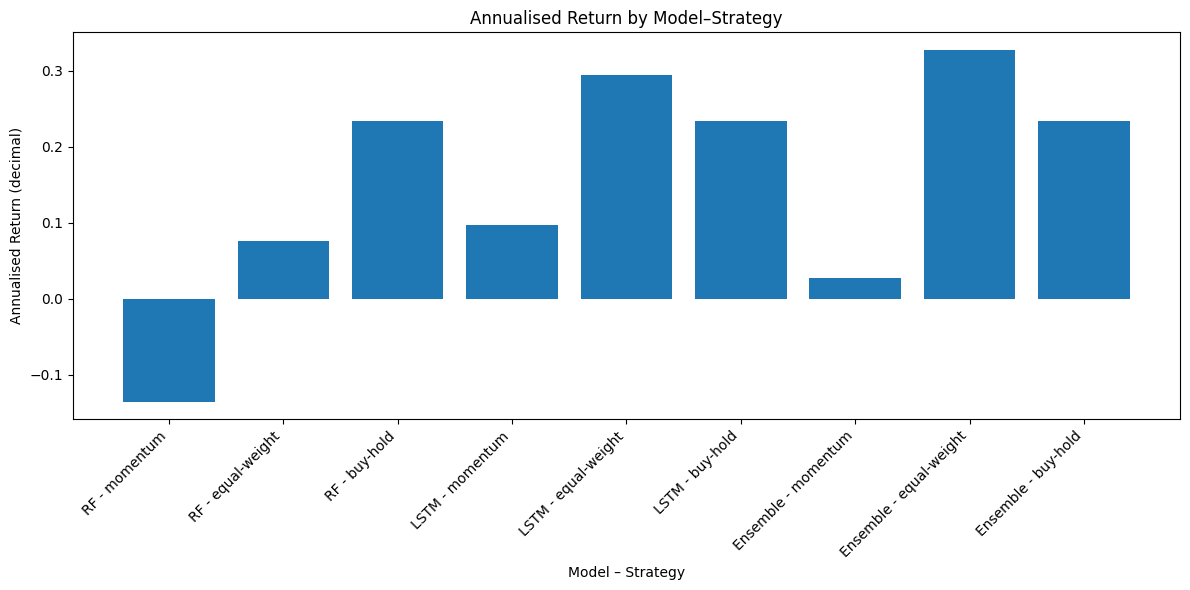

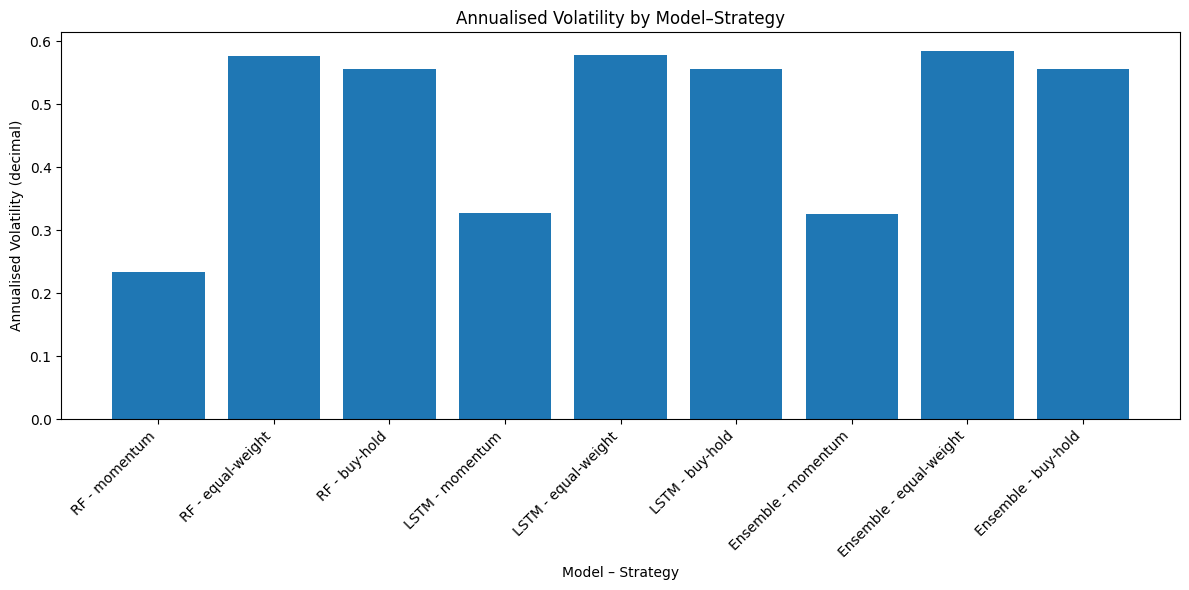

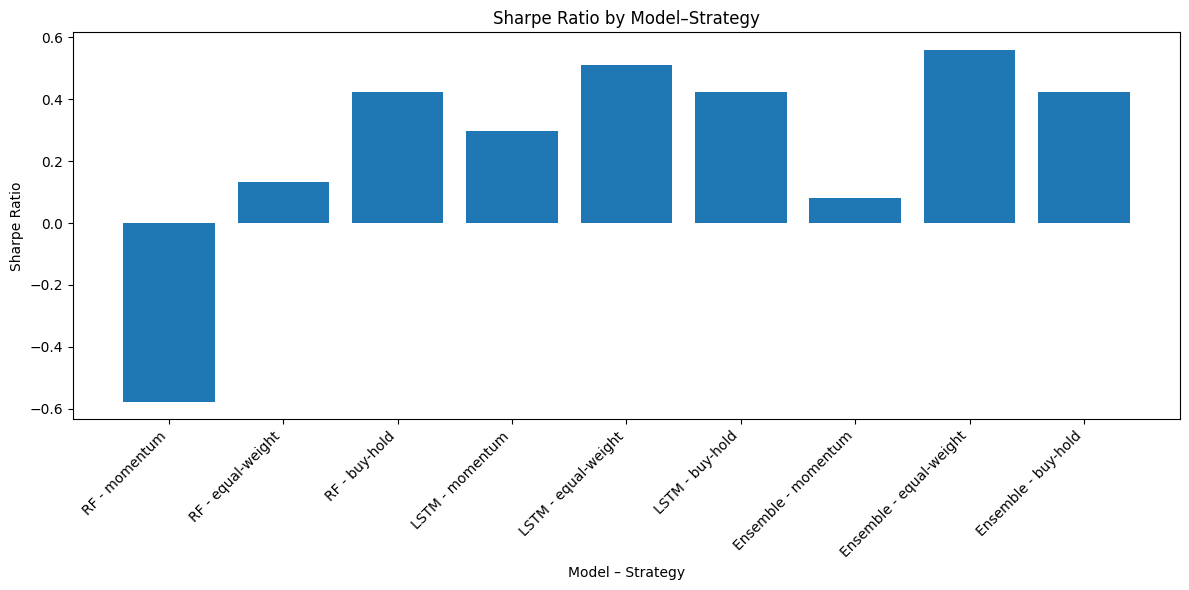

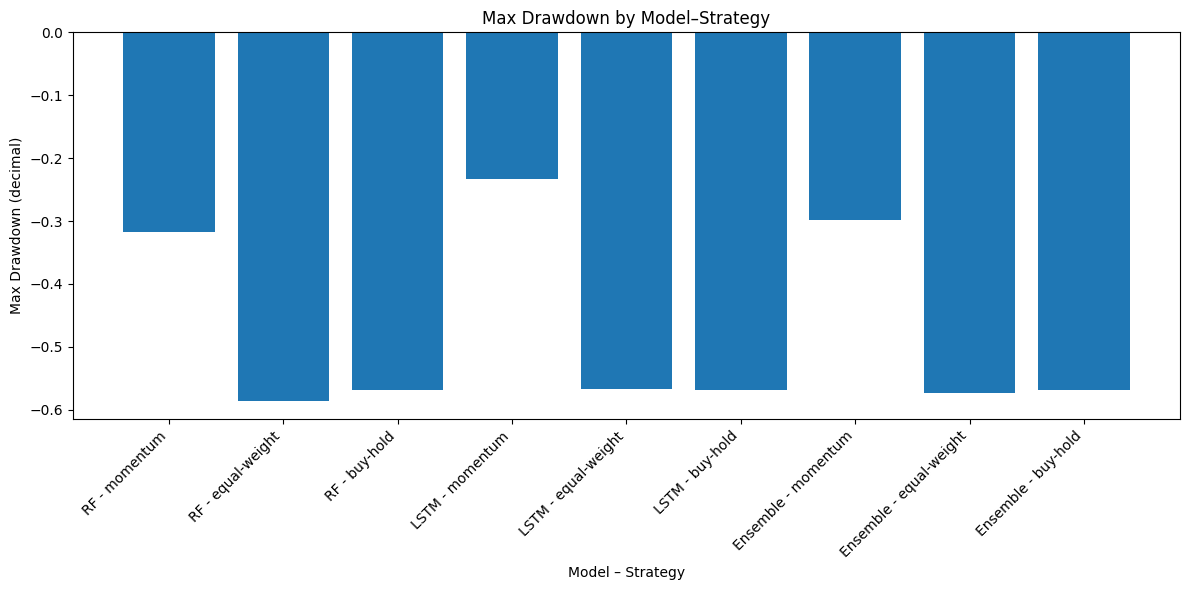

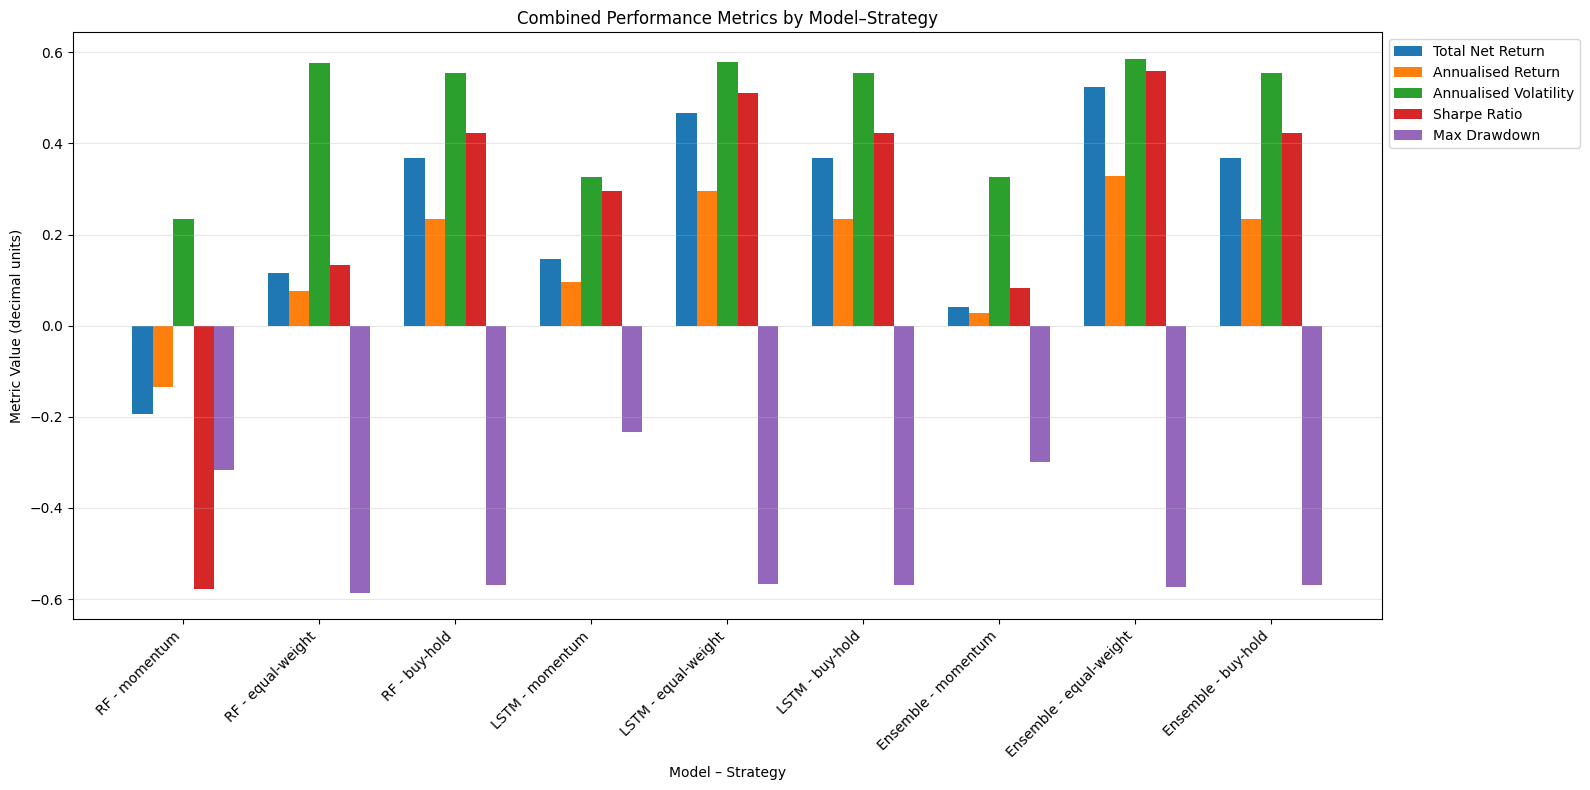

In [ ]:
# ============================================================
# CONFIG
# ============================================================
file_path = "crypto_prices_9yrs_full.xlsx"     # <-- DATA FILE
sheet_name = "Closing_Prices"
target_lookback = 5
rf_lags = 1
test_size_ratio = 0.2
rf_trees = 200
lstm_epochs = 20
random_state = 42
trading_days_per_year = 252
tc_per_unit = 0.0005     # transaction costs per turnover unit

# ============================================================
# 1) LOAD PRICES -> LOG RETURNS
# ============================================================
try:
    prices = pd.read_excel(file_path, sheet_name=sheet_name, index_col="Date", parse_dates=True)
except:
    prices = pd.read_excel(file_path, index_col=0, parse_dates=True)

prices = prices.sort_index()
returns = np.log(prices / prices.shift(1)).dropna()
tickers = returns.columns.tolist()

# ============================================================
# 2) TRAIN/TEST SPLIT
# ============================================================
split_idx = int(len(returns)*(1-test_size_ratio))
train_returns = returns.iloc[:split_idx]
test_returns = returns.iloc[split_idx:]

# ============================================================
# 3) RANDOM FOREST PREDICTIONS
# ============================================================
rf_preds = pd.DataFrame(index=test_returns.index, columns=tickers)

for asset in tickers:
    df = returns[[asset]].copy()
    df["lag1"] = df[asset].shift(1)
    df = df.dropna()

    train_df = df.iloc[:split_idx-1]
    test_df = df.iloc[split_idx-1:]

    X_train = train_df[["lag1"]].values
    y_train = train_df[asset].values
    X_test = test_df[["lag1"]].values

    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    rf = RandomForestRegressor(n_estimators=rf_trees, random_state=random_state)
    rf.fit(X_train_s, y_train)
    preds = rf.predict(X_test_s)

    rf_preds.loc[test_df.index, asset] = preds

# ============================================================
# 4) LSTM (multivariate)
# ============================================================
def create_sequences_mv(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lstm_preds = pd.DataFrame(index=test_returns.index, columns=tickers)

scaler_all = StandardScaler().fit(train_returns)
train_scaled = pd.DataFrame(scaler_all.transform(train_returns),
                            index=train_returns.index,
                            columns=tickers)
test_scaled = pd.DataFrame(scaler_all.transform(test_returns),
                           index=test_returns.index,
                           columns=tickers)
combined_scaled = pd.concat([train_scaled, test_scaled])

for asset in tickers:
    X_array = combined_scaled.values
    y_array = combined_scaled[asset].values

    Xs, ys = create_sequences_mv(X_array, y_array, target_lookback)

    seq_start = target_lookback
    seq_train_end = split_idx - seq_start

    X_train = Xs[:seq_train_end]
    y_train = ys[:seq_train_end]
    X_test = Xs[seq_train_end:]
    y_test = ys[seq_train_end:]

    model = Sequential([
        Input((target_lookback, len(tickers))),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train, epochs=lstm_epochs, batch_size=32, verbose=0)

    preds_scaled = model.predict(X_test, verbose=0).flatten()
    pred_dates = combined_scaled.index[seq_start+seq_train_end:seq_start+seq_train_end+len(X_test)]

    mapped = pd.Series(preds_scaled, index=pred_dates)
    lstm_preds[asset] = mapped.reindex(test_returns.index)

# ============================================================
# 5) ENSEMBLE (RF + LSTM)
# ============================================================
ensemble_preds = (rf_preds.astype(float) + lstm_preds.astype(float)) / 2
ensemble_preds = ensemble_preds.dropna()

test_returns_aligned = test_returns.loc[ensemble_preds.index]

# ============================================================
# 6) STRATEGIES + METRICS
# ============================================================
def compute_weights_and_daily_returns(preds, actual, mode):
    if mode == "momentum":
        signals = preds.applymap(lambda x: 1 if x > 0 else -1)
        weights = signals / len(preds.columns)
        daily = (weights * actual).sum(axis=1)

    elif mode == "equal-weight":
        pos = preds > 0
        counts = pos.sum(axis=1).replace(0, np.nan)
        weights = pos.div(counts, axis=0).fillna(0)
        daily = (weights * actual).sum(axis=1)

    else:  # buy-hold
        weights = pd.DataFrame(1/len(preds.columns),
                               index=preds.index, columns=preds.columns)
        daily = (weights * actual).sum(axis=1)

    cum = (1 + daily).cumprod()
    return daily, cum, weights

def compute_turnover(weights):
    prev = weights.shift(1).fillna(0)
    delta = (weights - prev).abs().sum(axis=1)
    return 0.5 * delta

def max_drawdown(cum):
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def annualized_return(daily):
    cumulative = (1 + daily).cumprod().iloc[-1]
    years = len(daily)/trading_days_per_year
    return cumulative**(1/years)-1

def annualized_vol(daily):
    return daily.std() * np.sqrt(trading_days_per_year)

def sharpe_ratio(daily):
    ann_ret = annualized_return(daily)
    ann_vol = annualized_vol(daily)
    return ann_ret/ann_vol if ann_vol>0 else np.nan

# ============================================================
# 7) RUN ALL MODELS × STRATEGIES
# ============================================================
models = {
    "RF": rf_preds.loc[test_returns_aligned.index],
    "LSTM": lstm_preds.loc[test_returns_aligned.index],
    "Ensemble": ensemble_preds
}

strategies = ["momentum", "equal-weight", "buy-hold"]

summary = []

for model_name, preds in models.items():
    for strat in strategies:
        daily, cum, weights = compute_weights_and_daily_returns(preds, test_returns_aligned, strat)
        turnover = compute_turnover(weights)
        tc = turnover * tc_per_unit
        net_daily = daily - tc
        cum_net = (1 + net_daily).cumprod()

        summary.append([
            model_name,
            strat,
            cum_net.iloc[-1] - 1,          # Total Net Return
            annualized_return(net_daily),  # Ann Return
            annualized_vol(net_daily),     # Ann Vol
            sharpe_ratio(net_daily),       # Sharpe
            max_drawdown(cum_net)          # Max Drawdown
        ])

summary_df = pd.DataFrame(summary,
                          columns=["Model","Strategy","TotalReturn",
                                   "AnnReturn","AnnVol","Sharpe","MaxDrawdown"])
print(summary_df)

# ============================================================
# 8) PLOT: CUMULATIVE RETURNS (net)
# ============================================================
plt.figure(figsize=(14,8))
for model_name, preds in models.items():
    for strat in strategies:
        daily, cum, weights = compute_weights_and_daily_returns(preds, test_returns_aligned, strat)
        net_daily = daily - compute_turnover(weights)*tc_per_unit
        cum_net = (1 + net_daily).cumprod()

        plt.plot(cum_net.index, cum_net.values,
                 label=f"{model_name} - {strat}")

plt.title("Cumulative Net Returns After Transaction Costs")
plt.xlabel("Date")               # <-- X-AXIS LABEL
plt.ylabel("Cumulative Return")  # <-- Y-AXIS LABEL
plt.grid(alpha=0.3)
plt.legend(loc="upper left", bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

# ============================================================
# 1) BAR CHART: Total Net Return
# ============================================================
plt.figure(figsize=(12,6))
plt.bar(summary_df.index, summary_df["TotalReturn"])
plt.title("Total Net Return by Model–Strategy")
plt.xlabel("Model – Strategy")
plt.ylabel("Total Net Return (decimal)")
plt.xticks(summary_df.index,
           summary_df["Model"] + " - " + summary_df["Strategy"],
           rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ============================================================
# 2) BAR CHART: Annualised Return
# ============================================================
plt.figure(figsize=(12,6))
plt.bar(summary_df.index, summary_df["AnnReturn"])
plt.title("Annualised Return by Model–Strategy")
plt.xlabel("Model – Strategy")
plt.ylabel("Annualised Return (decimal)")
plt.xticks(summary_df.index,
           summary_df["Model"] + " - " + summary_df["Strategy"],
           rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ============================================================
# 3) BAR CHART: Annualised Volatility
# ============================================================
plt.figure(figsize=(12,6))
plt.bar(summary_df.index, summary_df["AnnVol"])
plt.title("Annualised Volatility by Model–Strategy")
plt.xlabel("Model – Strategy")
plt.ylabel("Annualised Volatility (decimal)")
plt.xticks(summary_df.index,
           summary_df["Model"] + " - " + summary_df["Strategy"],
           rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ============================================================
# 4) BAR CHART: Sharpe Ratio
# ============================================================
plt.figure(figsize=(12,6))
plt.bar(summary_df.index, summary_df["Sharpe"])
plt.title("Sharpe Ratio by Model–Strategy")
plt.xlabel("Model – Strategy")
plt.ylabel("Sharpe Ratio")
plt.xticks(summary_df.index,
           summary_df["Model"] + " - " + summary_df["Strategy"],
           rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ============================================================
# 5) BAR CHART: Max Drawdown
# ============================================================
plt.figure(figsize=(12,6))
plt.bar(summary_df.index, summary_df["MaxDrawdown"])
plt.title("Max Drawdown by Model–Strategy")
plt.xlabel("Model – Strategy")
plt.ylabel("Max Drawdown (decimal)")
plt.xticks(summary_df.index,
           summary_df["Model"] + " - " + summary_df["Strategy"],
           rotation=45, ha="right")
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Assuming you have summary_df with columns:
# ["Model","Strategy","TotalReturn","AnnReturn","AnnVol","Sharpe","MaxDrawdown"]
# ------------------------------------------------------------

# Create x-labels combining model and strategy
labels = summary_df["Model"] + " - " + summary_df["Strategy"]
x = np.arange(len(labels))          # positions
width = 0.15                        # width of each bar

# Extract metric arrays
total_ret   = summary_df["TotalReturn"].values
ann_ret     = summary_df["AnnReturn"].values
ann_vol     = summary_df["AnnVol"].values
sharpe      = summary_df["Sharpe"].values
max_dd      = summary_df["MaxDrawdown"].values

plt.figure(figsize=(16,8))

# Five bar groups (color-coded)
plt.bar(x - 2*width, total_ret,  width, label="Total Net Return",      )
plt.bar(x - width,   ann_ret,    width, label="Annualised Return",      )
plt.bar(x,           ann_vol,    width, label="Annualised Volatility",  )
plt.bar(x + width,   sharpe,     width, label="Sharpe Ratio",           )
plt.bar(x + 2*width, max_dd,     width, label="Max Drawdown",           )

# Titles & axis labels (include units)
plt.title("Combined Performance Metrics by Model–Strategy")
plt.xlabel("Model – Strategy")
plt.ylabel("Metric Value (decimal units)")
plt.xticks(x, labels, rotation=45, ha="right")

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
